The intention of this notebook is to track and summary the performances of the run models.

In [1]:
!conda list

# packages in environment at /home/ec2-user/anaconda3/envs/gnnNb2803:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       2_gnu    conda-forge
appdirs                   1.4.4              pyhd3eb1b0_0    anaconda
asttokens                 2.0.5              pyhd3eb1b0_0    anaconda
backcall                  0.2.0              pyhd3eb1b0_0    anaconda
blas                      1.0                         mkl    anaconda
brotli                    1.0.9                h5eee18b_7    anaconda
brotli-bin                1.0.9                h5eee18b_7    anaconda
brotlipy                  0.7.0                    pypi_0    pypi
bzip2                     1.0.8                h7b6447c_0    anaconda
ca-certificates           2023.01.10           h06a4308_0    anaconda
certifi                   2022.12.7                pypi_0    pypi
cffi                   

In [26]:
import sys
import os
import pickle
import random
import torch
import torch.nn as nn
import tqdm as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sys.path.append('/home/ec2-user/SageMaker/projects/gnn/GNN-material/src')
sys.path = list(set(sys.path))

from tabulate import tabulate
from torch_geometric.data    import Dataset
# from models.TabTab.tab_tab  import TabTab_v1, TabTabDataset, create_tab_tab_datasets, BuildTabTabModel
from models.GraphTab.graph_tab import GraphTab_v1, GraphTab_v2, GraphTabDataset, create_graph_tab_datasets, BuildGraphTabModel
from models.TabGraph.tab_graph import TabGraph_v1, TabGraphDataset, create_tab_graph_datasets, BuildTabGraphModel

from models.TabTab.tab_tab_early_stopping  import TabTabDataset, create_tt_loaders, BuildTabTabModel, TabTab

from utils.global_vars import PlottingParameters
from torch_geometric.loader  import DataLoader as PyG_DataLoader
from sklearn.preprocessing import StandardScaler

import random
import numpy as np
import torch

# Set the random seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

os.environ['TORCH'] = torch.__version__

print(f"Python version: {'.'.join(map(str, sys.version_info[:3]))}")
print(f"Pytorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")

Python version: 3.10.4
Pytorch version: 1.12.0
CUDA version: 10.2


In [4]:
!ls -lh ../performances

total 149M
drwxrwxr-x 2 ec2-user ec2-user 4.0K Mar 31 23:06 combined_score_threshs
-rw-rw-r-- 1 ec2-user ec2-user 1.7M Dec  8 13:54 ic50s_test_gdsc2_v1_100epochs.csv
drwxrwxr-x 3 ec2-user ec2-user 4.0K Dec  8 13:03 imgs
-rw-rw-r-- 1 ec2-user ec2-user  29K Mar  5 17:27 logfile_model_graphgraph_v1_gdsc2_950_42_040323Thresh950GATConv3GINConvMax100Epochs
-rw-rw-r-- 1 ec2-user ec2-user 7.4K Mar  4 17:29 logfile_model_graphgraph_v1_gdsc2_990_42_040323GATConv3GINConvMax100Epochs
-rw-rw-r-- 1 ec2-user ec2-user  34K Feb 16 21:40 logfile_model_graphgraph_v1_gdsc2_990_42_130223GATConv2GINConvMax
-rw-rw-r-- 1 ec2-user ec2-user  36K Feb 16 21:40 logfile_model_graphgraph_v1_gdsc2_990_42_130223GATConv2GINConvMax200Epochs
-rw-rw-r-- 1 ec2-user ec2-user  36K Feb 14 02:39 logfile_model_graphgraph_v1_gdsc2_990_42_130223GATConv3GINConvMax200Epochs128only
-rw-rw-r-- 1 ec2-user ec2-user 143K Feb 16 00:41 logfile_model_graphgraph_v1_gdsc2_990_42_150223GCNConv2GINConvMax200Epochs
-rw-rw-r-- 1 ec2-user ec2-use

<ins>Contents of this notebook</ins>

- [x] Compared performances of v1 models TabTab, GraphTab, TabGraph
- [x] Plot the predicted IC50 values against the actual IC50 values for the test set for each model
    - x-axis = observed IC50 values
    - y-axis = predicted IC50 values
    - include histograms on the edges of the scatter plot
- [ ] Calculate average predicted IC50 value per drug
    - [ ] For that, save the cell-line name an drug as well in the `ic50s` table
    - [ ] standardize by dividing by the average per drug
    - [ ] compare the top 10 and bottom 10 drugs
- [ ] Ran GNNExplainer on GraphTab
- [ ] Ran GNNExplainer on TabGraph

# Model Performances

## Helpers

In [5]:
def plot_model_results(df, model):
    fig, axs = plt.subplots(2, 4, figsize=(30, 10))

    sns.lineplot(x='epochs', y='mse', hue='dataset', data=df, ax=axs[0,0]);
    sns.lineplot(x='epochs', y='rmse', hue='dataset', data=df, ax=axs[0,1]);
    sns.lineplot(x='epochs', y='mae', hue='dataset', data=df, ax=axs[1,0]);
    sns.lineplot(x='epochs', y='pcorr', hue='dataset', data=df, ax=axs[1,1]);

    axs[0,0].set_title('MSE');
    axs[0,1].set_title('RMSE');
    axs[1,0].set_title('MAE');
    axs[1,1].set_title('Pearson Correlation');

    sns.boxplot(x='mse', y='dataset', data=df, showfliers=False, ax=axs[0,2]);
    sns.boxplot(x='rmse', y='dataset', data=df, showfliers=False, ax=axs[0,3]);
    sns.boxplot(x='mae', y='dataset', data=df, showfliers=False, ax=axs[1,2]);
    sns.boxplot(x='pcorr', y='dataset', data=df, showfliers=False, ax=axs[1,3]);

    axs[0,2].set_title('MSE'); axs[0,2].set(xlabel=None);
    axs[0,3].set_title('RMSE'); axs[0,3].set(xlabel=None);
    axs[1,2].set_title('MAE'); axs[1,2].set(xlabel=None);
    axs[1,3].set_title('Pearson Correlation'); axs[1,3].set(xlabel=None);

    fig.suptitle(f'{model} Model');
    plt.show();
    
class HyperParameters:
    def __init__(self, batch_size, lr, train_ratio, val_ratio, 
                 num_epochs, seed='12345', num_workers=0):
        self.BATCH_SIZE = batch_size
        self.LR = lr
        self.TRAIN_RATIO = train_ratio
        self.TEST_VAL_RATIO = 1-self.TRAIN_RATIO
        self.VAL_RATIO = val_ratio
        self.NUM_EPOCHS = num_epochs
        self.RANDOM_SEED = seed
        self.NUM_WORKERS = num_workers

def get_data_for_model_validation(mod, 
                                  create, 
                                  Model, 
                                  BuildModel, 
                                  drm, 
                                  cl, 
                                  sm, 
                                  seed, 
                                  approach):
    """Returns instantiated model class for the given model type and datasets."""
    hyper_params = HyperParameters(
        batch_size=mod['batch_size'], 
        lr=mod['learning_rate'], 
        train_ratio=mod['train_ratio'], 
        val_ratio=mod['val_ratio'], 
        num_epochs=mod['epoch'], 
        seed=seed,
        num_workers=0
    )
    
#     print(drm.shape)
#     print(cl.shape)
#     print(sm.shape)

    train_loader, test_loader, val_loader = create(drm, cl, sm, hyper_params)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if approach in ['TabTab', 'TabGraph']:
        model = Model(cl.shape[1]).to(device)
    elif approach == 'GraphTab':
        model = Model().to(device)
    model.load_state_dict(mod['model_state_dict'], strict=False)
    loss_func = nn.MSELoss()
    optimizer = torch.optim.Adam(params=model.parameters(), 
                                 lr=mod['learning_rate'])    

    build_model = BuildModel(
        model=model, 
        criterion=loss_func, 
        optimizer=optimizer,
        num_epochs=mod['epoch'], 
        train_loader=train_loader,
        test_loader=test_loader, 
        val_loader=val_loader, 
        device=device
    )
    
    return build_model

def calculate_and_return_metrics(model, 
                                 test_res, 
                                 ic50s, 
                                 model_name):
    """Calculate and return MSE, RMSE, MAE, r2 and pearson correlation coefficient
    for train, validation and test set for the given model."""
    mse_train, rmse_train, mae_train, r2_train, pcc_train, scc_train, _, _ = model.validate(model.train_loader)
    mse_val, rmse_val, mae_val, r2_val, pcc_val, scc_val, _, _ = model.validate(model.val_loader)
    mse_test, rmse_test, mae_test, r2_test, pcc_test, scc_test, y_true_test, y_pred_test = model.validate(model.test_loader)

    test_res.iloc[test_res.model==model_name, 1:] = pd.Series([
        mse_test.item(), rmse_test.item(), mae_test, r2_test, pcc_test, scc_test
    ])

    results = tabulate(
        [
            ['mse', 'rmse', 'mae', 'r2', 'pcc', 'scc'],
            ['train', mse_train, rmse_train, mae_train, r2_train, pcc_train, scc_train],
            ['validation', mse_val, rmse_val, mae_val, r2_val, pcc_val, scc_val],
            ['test', mse_test, rmse_test, mae_test, r2_test, pcc_test, scc_test]
        ], headers='firstrow')
    print(results)

    data = np.stack([
        np.repeat(model_name, len(y_true_test)),
        list([v.item() for v in y_true_test]), 
        list([v.item() for v in y_pred_test])
    ], axis=1)

    if model_name not in list(ic50s.model.unique()):
        ic50s = pd.concat([ic50s, pd.DataFrame(data, columns=ic50s.columns)], axis=0)  
        
    return test_res, ic50s

def plot_observed_vs_predicted_ln_ic50s(ic50s: pd.DataFrame, 
                                        rmse: float,
                                        pcc: float,
                                        scc: float,
                                        model_name: str,
                                        version: str):
    """Plot the observed ln(IC50) value against the predicted ones."""
    ax = sns.jointplot(x='y_true', y='y_pred', data=ic50s, kind='hex',
                       marginal_kws={'bins': 35});
    ax.fig.set_size_inches(8, 6);

    plt.xlabel(r'Observed $\ln(IC_{50})$');
    plt.ylabel(r'Predicted $\ln(IC_{50})$');
    plt.xticks(np.arange(-10, 11, 2.5));
    plt.yticks(np.arange(-10, 11, 2.5));

    plt.text(-9, 8.5, 
             f"RMSE={round(rmse, 2)}", 
             horizontalalignment='left', size=18, color='black');
    plt.text(-9, 7.4, 
             f"PCC={round(pcc, 2)}", 
             horizontalalignment='left', size=18, color='black');
    plt.text(-9, 6.3, 
             f"SCC={round(scc, 2)}", 
             horizontalalignment='left', size=18, color='black');    

    plt.title(f'{model_name} {version}', y=1.25);
    plt.show();
    
    return ax.fig


class GraphTabDataset(Dataset): 
    def __init__(self, cl_graphs, drugs, drug_response_matrix):
        super().__init__()

        # SMILES fingerprints of the drugs and cell-line graphs.
        self.drugs = drugs
        self.cell_line_graphs = cl_graphs

        # Lookup datasets for the response values.
        drug_response_matrix.reset_index(drop=True, inplace=True)
        self.cell_lines = drug_response_matrix['CELL_LINE_NAME']
        self.drug_ids = drug_response_matrix['DRUG_ID']
        self.drug_names = drug_response_matrix['DRUG_NAME']
        self.ic50s = drug_response_matrix['LN_IC50']

    def len(self):
        return len(self.ic50s)

    def get(self, idx: int):
        """
        Returns a tuple of cell-line, drug and the corresponding ln(IC50)
        value for a given index.

        Args:
            idx (`int`): Index to specify the row in the drug response matrix.  
        Returns:
            `Tuple[torch_geometric.data.data.Data, np.ndarray, np.float64]`:
            Tuple of a cell-line graph, drug SMILES fingerprint and the 
            corresponding ln(IC50) value.
        """
        assert self.cell_lines.iloc[idx] in self.cell_line_graphs.keys(), \
            f"Didn't find CELLLINE: {self.cell_line_graphs.iloc[idx]}"        
        assert self.drug_ids.iloc[idx] in self.drugs.keys(), \
            f"Didn't find DRUG: {self.drug_ids.iloc[idx]}"
        return (self.cell_line_graphs[self.cell_lines.iloc[idx]], 
                self.drugs[self.drug_ids.iloc[idx]],
                self.ic50s.iloc[idx])

    def print_dataset_summary(self):
        print(f"GraphTabDataset Summary")
        print(f"{23*'='}")
        print(f"# observations : {len(self.ic50s)}")
        print(f"# cell-lines   : {len(np.unique(self.cell_lines))}")
        print(f"# drugs        : {len(np.unique(self.drug_names))}")
        print(f"# genes        : {self.cell_line_graphs[next(iter(self.cell_line_graphs))].x.shape[0]}")
        
def create_graph_tab_datasets(drm, cl_graphs, drug_mat, args):
    print(f"Full     shape: {drm.shape}")
    train_set, test_val_set = train_test_split(drm, 
                                               test_size=args.TEST_VAL_RATIO, 
                                               random_state=args.RANDOM_SEED,
                                               stratify=drm['CELL_LINE_NAME'])
    test_set, val_set = train_test_split(test_val_set,
                                         test_size=args.VAL_RATIO,
                                         random_state=args.RANDOM_SEED,
                                         stratify=test_val_set['CELL_LINE_NAME'])
    print(f"train    shape: {train_set.shape}")
    print(f"test_val shape: {test_val_set.shape}")
    print(f"test     shape: {test_set.shape}")
    print(f"val      shape: {val_set.shape}")

    train_dataset = GraphTabDataset(cl_graphs=cl_graphs, drugs=drug_mat, drug_response_matrix=train_set)
    test_dataset = GraphTabDataset(cl_graphs=cl_graphs, drugs=drug_mat, drug_response_matrix=test_set)
    val_dataset = GraphTabDataset(cl_graphs=cl_graphs, drugs=drug_mat, drug_response_matrix=val_set)

    print("train_dataset:")
    train_dataset.print_dataset_summary()
    print("test_dataset:")
    test_dataset.print_dataset_summary()
    print("val_dataset:")
    val_dataset.print_dataset_summary()

    # TODO: try out different `num_workers`.
    train_loader = PyG_DataLoader(dataset=train_dataset, batch_size=args.BATCH_SIZE, shuffle=True, num_workers=args.NUM_WORKERS)
    test_loader = PyG_DataLoader(dataset=test_dataset, batch_size=args.BATCH_SIZE, shuffle=True, num_workers=args.NUM_WORKERS)
    val_loader = PyG_DataLoader(dataset=val_dataset, batch_size=args.BATCH_SIZE, shuffle=True, num_workers=args.NUM_WORKERS)

    return train_loader, test_loader, val_loader           

## Train, Validation and Test Results

In [8]:
# --- Results for combined_score_thresh=900 & GDSC2---
# tt = torch.load('../performances/model_performance_TabTab_gdsc2_990.pth')
gt = torch.load('../performances/model_performance_GraphTab_v2_gdsc2_990.pth')
tg = torch.load('../performances/model_performance_TabGraph_gdsc2_990.pth')

tt = torch.load('../performances/model_performance_TabTab_v1_gdsc2_990_42_050223.pth', map_location=torch.device('cpu'))

device = torch.device('cpu')
tt.keys()

dict_keys(['num_epochs', 'batch_size', 'learning_rate', 'train_ratio', 'val_ratio', 'kfold', 'early_stopping_thresh', 'model_state_dict', 'optimizer_state_dict', 'performances'])

In [11]:
models = {
    'TabTab': tt,
    'GraphTab': gt,
    'TabGraph': tg
}

In [13]:
tt.keys()

dict_keys(['num_epochs', 'batch_size', 'learning_rate', 'train_ratio', 'val_ratio', 'kfold', 'early_stopping_thresh', 'model_state_dict', 'optimizer_state_dict', 'performances'])

In [14]:
train_val_per_model = dict()

for name, res in models.items():
    ds = ['train', 'val']
    dfs = []
    for d in ds:
        epochs = range(1, res['epoch']+1)
        mse = [x.item() for x in res[f'{d}_performances']['mse']]
        rmse = [x.item() for x in res[f'{d}_performances']['rmse']]
        mae = [x.item() for x in res[f'{d}_performances']['mae']]
        r2 = [x.item() for x in res[f'{d}_performances']['r2']]
        pcorr = [x[0] if d=='train' else x for x in res[f'{d}_performances']['pcorr']]
        if d=='train':
            epochtimes = [x for x in res[f'{d}_performances']['epoch_times']]
        else: 
            epochtimes = [None for e in epochs]
            
        dfs.append(pd.DataFrame({
            'dataset': d,
            'epochs': epochs,
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'pcorr': pcorr,
            'epoch_times': epochtimes
        }))  
        
    trainval = pd.concat([dfs[0], dfs[1]])
    train_val_per_model[name] = trainval
    
train_val_per_model.keys()

KeyError: 'train_performances'

In [15]:
test_res = pd.DataFrame({
    'model': ['TabTab', 'GraphTab', 'TabGraph'],
    'mse': [None, None, None],
    'rmse': [None, None, None],
    'mae': [None, None, None],
    'r2': [None, None, None],
    'pcc': [None, None, None],
    'scc': [None, None, None]
})
test_res

,model,mse,rmse,mae,r2,pcc,scc
0,TabTab,None,None,None,None,None,None
1,GraphTab,None,None,None,None,None,None
2,TabGraph,None,None,None,None,None,None


In [16]:
# TODO: Save the cell-line name and drug as well in the below table.
ic50s = pd.DataFrame(columns=['model', 'y_true', 'y_pred'])
ic50s

,model,y_true,y_pred


### TabTab

In [17]:
plot_model_results(train_val_per_model['TabTab'], 'TabTab')

KeyError: 'TabTab'

In [17]:
drm[drm.CELL_LINE_NAME=='PFSK-1'].LN_IC50.hist(bins=50);

NameError: name 'drm' is not defined

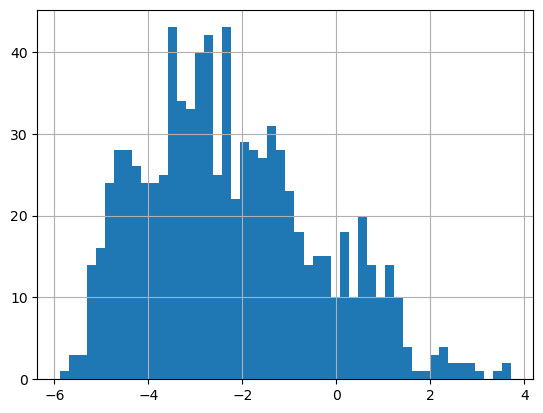

In [36]:
drm[drm.DRUG_ID==1003].LN_IC50.hist(bins=50);

In [44]:
'CR-12' in list(drm.CELL_LINE_NAME.unique())

False

In [132]:
from torch_geometric.data    import Dataset
from sklearn.model_selection import train_test_split
# from torch_geometric.loader  import DataLoader as PyG_DataLoader
from torch.utils.data        import DataLoader
from torch_geometric.nn      import Sequential, GCNConv, global_mean_pool, global_max_pool
from tqdm                    import tqdm
from time                    import sleep
from sklearn.metrics         import r2_score, mean_absolute_error
from scipy.stats             import pearsonr, spearmanr
import random
import numpy as np
import torch

# Set the random seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


class TabTabDataset(Dataset): 
    def __init__(self, cl_mat, drug_mat, drm):
        super().__init__()      
        self.cl_mat = cl_mat
        self.drug_mat = drug_mat

        drm.reset_index(drop=True, inplace=True)
        self.cls = drm['CELL_LINE_NAME']
        self.drug_ids = drm['DRUG_ID']
        self.drug_names = drm['DRUG_NAME']
        self.ic50s = drm['LN_IC50']

    def len(self):
        return len(self.ic50s)

    def get(self, idx: int):
        """
        Returns a tuple of cell-line-gene features, drug smiles fingerprints 
        and the corresponding ln(IC50) values for a given index.

        Args:
            idx (`int`): Index to specify the row in the drug response matrix.  
        Returns
            `Tuple[np.ndarray, np.ndarray, np.float64]]`: Tuple of cell-line 
                gene feature values, drug SMILES fingerprints and the 
                corresponding ln(IC50) target values.
        """  
        return (self.cl_mat.loc[self.cls.iloc[idx]], 
                self.drug_mat.loc[self.drug_ids.iloc[idx]],
                self.ic50s.iloc[idx])

    def print_dataset_summary(self):
        print(f"TabTabDataset Summary")
        print(21*'=')
        print(f"# observations : {len(self.ic50s)}")
        print(f"# cell-lines   : {len(np.unique(self.cls))}")
        print(f"# drugs        : {len(np.unique(self.drug_names))}")
        print(f"# genes        : {len([col for col in self.cl_mat.columns[1:] if '_cnvg' in col])}")


def _collate_tab_tab(samples):
    cell_lines, drugs, ic50s = map(list, zip(*samples))
    cell_lines = [torch.tensor(cl, dtype=torch.float64) for cl in cell_lines]
    drugs = [torch.tensor(drug, dtype=torch.float64) for drug in drugs]
    
    return torch.stack(cell_lines, 0), torch.stack(drugs, 0), torch.tensor(ic50s)

def create_tab_tab_datasets(drm, cl_mat, drug_mat, args):
    train_set, test_val_set = train_test_split(drm, 
                                               test_size=args.TEST_VAL_RATIO,
                                               random_state=args.RANDOM_SEED,
                                               stratify=drm['CELL_LINE_NAME'])
    test_set, val_set = train_test_split(test_val_set, 
                                         test_size=args.VAL_RATIO, 
                                         random_state=args.RANDOM_SEED,
                                         stratify=test_val_set['CELL_LINE_NAME'])

    print(f"train_set.shape: {train_set.shape}")
    print(f"test_set.shape: {test_set.shape}")
    print(f"val_set.shape: {val_set.shape}")

    train_dataset = TabTabDataset(cl_mat=cl_mat, 
                                  drug_mat=drug_mat, 
                                  drm=train_set)
    test_dataset = TabTabDataset(cl_mat=cl_mat, 
                                 drug_mat=drug_mat, 
                                 drm=test_set)
    val_dataset = TabTabDataset(cl_mat=cl_mat, 
                                drug_mat=drug_mat, 
                                drm=val_set)

    print("train_dataset"); train_dataset.print_dataset_summary()
    print("test_dataset"); test_dataset.print_dataset_summary()
    print("val_dataset"); val_dataset.print_dataset_summary()

    train_loader = DataLoader(dataset=train_dataset, 
                              batch_size=args.BATCH_SIZE, 
                              shuffle=True, 
                              collate_fn=_collate_tab_tab, 
                              num_workers=args.NUM_WORKERS)
    test_loader = DataLoader(dataset=test_dataset, 
                             batch_size=args.BATCH_SIZE, 
                             shuffle=True, 
                             collate_fn=_collate_tab_tab, 
                             num_workers=args.NUM_WORKERS)
    val_loader = DataLoader(dataset=val_dataset, 
                            batch_size=args.BATCH_SIZE, 
                            shuffle=True, 
                            collate_fn=_collate_tab_tab, 
                            num_workers=args.NUM_WORKERS)  

    return train_loader, test_loader, val_loader 

In [94]:
import inspect 

print(inspect.isabstract(TabTabDataset)) # output: True

False


In [95]:
drm.head(2)

,DATASET,CELL_LINE_NAME,DRUG_NAME,DRUG_ID,SANGER_MODEL_ID,AUC,RMSE,Z_SCORE,LN_IC50
333161,GDSC2,PFSK-1,Camptothecin,1003,SIDM01132,0.930105,0.088999,0.432482,-1.462148
333162,GDSC2,A673,Camptothecin,1003,SIDM00848,0.614932,0.111423,-1.420322,-4.869447


In [122]:
drm_idxs = []

drm.loc[
    (drm['CELL_LINE_NAME']==model.test_loader.dataset.cls[0]) &\
    (drm['DRUG_ID']==model.test_loader.dataset.drug_ids[0])
]

,DATASET,CELL_LINE_NAME,DRUG_NAME,DRUG_ID,SANGER_MODEL_ID,AUC,RMSE,Z_SCORE,LN_IC50
442183,GDSC2,NCI-H1793,WZ4003,1614,SIDM00755,0.967656,0.094367,1.893422,6.7614


In [153]:
import random
import numpy as np
import torch

# Set the random seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

_, _, _, _, _, _, y_true, y_pred = model.validate(model.test_loader)

Iteration (val): 100%|██████████| 14/14 [00:04<00:00,  3.34it/s]


In [154]:
y_true[:10]

tensor([[-0.4452],
        [ 6.3101],
        [-0.7260],
        [ 3.8503],
        [ 5.5108],
        [ 3.2620],
        [ 2.2634],
        [-1.0496],
        [ 2.7416],
        [ 4.6761]], device='cuda:0', dtype=torch.float64)

In [155]:
y_pred[:10]

tensor([[ 0.1753],
        [ 6.2316],
        [ 0.1266],
        [ 3.4520],
        [ 5.2459],
        [ 2.6129],
        [ 1.8340],
        [-0.0316],
        [ 3.3852],
        [ 4.3177]], device='cuda:0')

In [ ]:
plt.plot(y_true,)

In [157]:
# Get the top 3 and bottom 3 indices based on y_pred
top_indices = torch.argsort(y_pred.flatten(), descending=True)[:3]
bottom_indices = torch.argsort(y_pred.flatten())[:3]

# Get the y values of the top and bottom indices from y_true
top_y_values = y_true[top_indices].flatten()
bottom_y_values = y_true[bottom_indices].flatten()

print("Top 3 y values: ", top_y_values)
print("Bottom 3 y values: ", bottom_y_values)

Top 3 y values:  tensor([8.4612, 8.3051, 8.5175], device='cuda:0', dtype=torch.float64)
Bottom 3 y values:  tensor([-6.4931, -6.2908, -6.9633], device='cuda:0', dtype=torch.float64)


In [127]:
for data in tqdm(model.test_loader, desc='Iteration (val)'):
    cl, dr, ic50 = data
    break

Iteration (val):   0%|          | 0/14 [00:00<?, ?it/s]


In [131]:
ic50[0].item()

-0.44524

In [124]:
for i, cl in enumerate(model.test_loader.dataset.cls):
    print(model.test_loader.dataset.ic50s[i])
    print(y_true[i].item())
    print(y_pred[i].item())    
    break
    assert model.test_loader.dataset.ic50s[i] == y_true[i]
#     drm.loc[
#         (drm['CELL_LINE_NAME']==model.test_loader.dataset.cls[0]) &\
#         (drm['DRUG_ID']==model.test_loader.dataset.drug_ids[0])
#     ]

6.7614
-0.44524
0.17527559399604797


In [120]:
# [y for y in y_true if y in model.test_loader.dataset.ic50s.values.tolist()][:10]
6.7614 in y_true

True

In [81]:
model.test_loader.dataset.cl_mat

,PLK1_gexpr,RUVBL1_gexpr,TERT_gexpr,EIF4EBP1_gexpr,RPS6_gexpr,STXBP1_gexpr,CDC42_gexpr,SFN_gexpr,POLB_gexpr,CBLB_gexpr,...,MYC_mut,CCNB1_mut,TICAM1_mut,CENPE_mut,CFLAR_mut,AKT1_mut,FBXO11_mut,PSMB8_mut,PRKCD_mut,FBXO7_mut
CELL_LINE_NAME,,,,,,,,,,,,,,,,,,,,,
22RV1,3.376377,7.935522,3.222590,9.062096,12.713941,4.554855,4.461362,8.570664,8.331353,3.500326,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
23132-87,3.525281,8.745985,3.329384,10.303132,12.802973,4.206494,4.112894,9.069540,8.788701,3.211637,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
42-MG-BA,3.769823,6.651761,3.492581,9.790909,11.856622,5.397945,4.457850,3.673494,7.443434,3.687171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
451Lu,3.922186,8.386289,3.479026,9.408780,12.290141,6.228226,5.412469,4.064795,8.272650,3.561098,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5637,3.531716,8.347308,3.243133,9.884705,12.588677,3.683614,4.389642,9.927606,8.998844,3.568646,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YT,4.341802,7.210758,4.218221,5.066651,12.541849,4.349122,4.705772,3.869999,8.501807,4.247007,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
ZR-75-30,3.787488,8.044024,3.555179,7.570786,12.448904,4.277296,4.164836,6.757498,8.172065,3.450698,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
huH-1,4.174036,7.574478,4.362433,8.393432,11.945708,4.259743,4.266904,8.369666,7.171742,3.158789,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
y_true[:10]

tensor([[-4.2599],
        [ 4.5619],
        [ 1.8739],
        [ 1.9473],
        [ 3.1005],
        [ 3.8748],
        [ 0.2483],
        [ 4.2073],
        [-0.0832],
        [-4.2522]], device='cuda:0', dtype=torch.float64)

In [63]:
model.test_loader.dataset.ic50s[:10]

0    6.761400
1   -1.244502
2    3.295330
3    2.527832
4   -2.414236
5    6.546359
6    2.231479
7    4.473221
8    1.984911
9    2.534399
Name: LN_IC50, dtype: float64

In [31]:
tt.keys()

dict_keys(['num_epochs', 'batch_size', 'learning_rate', 'train_ratio', 'val_ratio', 'kfold', 'early_stopping_thresh', 'model_state_dict', 'optimizer_state_dict', 'performances'])

In [32]:
cl.head(3)

,PLK1_gexpr,RUVBL1_gexpr,TERT_gexpr,EIF4EBP1_gexpr,RPS6_gexpr,STXBP1_gexpr,CDC42_gexpr,SFN_gexpr,POLB_gexpr,CBLB_gexpr,...,MYC_mut,CCNB1_mut,TICAM1_mut,CENPE_mut,CFLAR_mut,AKT1_mut,FBXO11_mut,PSMB8_mut,PRKCD_mut,FBXO7_mut
CELL_LINE_NAME,,,,,,,,,,,,,,,,,,,,,
22RV1,3.376377,7.935522,3.222590,9.062096,12.713941,4.554855,4.461362,8.570664,8.331353,3.500326,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
23132-87,3.525281,8.745985,3.329384,10.303132,12.802973,4.206494,4.112894,9.069540,8.788701,3.211637,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
42-MG-BA,3.769823,6.651761,3.492581,9.790909,11.856622,5.397945,4.457850,3.673494,7.443434,3.687171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
tab_tab_dataset = TabTabDataset(
    cl, 
    smiles,
    drm
)

TypeError: Can't instantiate abstract class TabTabDataset with abstract methods get, len

In [37]:
drm.shape

(137835, 9)

In [33]:
tab_tab_dataset = TabTabDataset(
    cl, 
    smiles, 
    drm
)
logging.info("Finished building TabTabDataset!")
tab_tab_dataset.print_dataset_summary()   

drm_train, drm_test = train_test_split(
    drm, 
    test_size=0.2,
    random_state=42,
    stratify=drm['CELL_LINE_NAME']
)

# Create data loaders.
train_loader, test_loader = create_tt_loaders(
    drm_train,
    drm_test,
    cl_gene_mat,
    smiles_mat,
    args
)
logging.info(f"{4*' '}Finished creating pytorch training datasets!")
logging.info(f"{4*' '}Number of batches per dataset:")
logging.info(f"{8*' '}train : {len(train_loader)}")      
logging.info(f"{8*' '}test  : {len(test_loader)}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"device: {device}")

# Initialize model.
model = tt
logging.info(f"Number of GPUs: {torch.cuda.device_count()}")
logging.info(f"GPU Usage: {torch.cuda.max_memory_allocated(device=device)}")

# Enable multi-GPU parallelization if feasible.
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model).to(device)
else:
    model =  model.to(device)

# Define loss function and optimizer.
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(
    params=model.parameters(), 
    lr=args.lr,
    weight_decay=args.weight_decay
)

# Build the model.
build_model = BuildTabTabModel(
    model=model, 
    criterion=loss_func, 
    optimizer=optimizer,
    num_epochs=args.num_epochs, 
    train_loader=train_loader,
    test_loader=test_loader,
    early_stopping_threshold=args.early_stopping_threshold,            
    device=device
)

TypeError: Can't instantiate abstract class TabTabDataset with abstract methods get, len

In [21]:
tt.keys()

dict_keys(['num_epochs', 'batch_size', 'learning_rate', 'train_ratio', 'val_ratio', 'kfold', 'early_stopping_thresh', 'model_state_dict', 'optimizer_state_dict', 'performances'])

In [24]:
create_tt_loaders

<function models.TabTab.tab_tab_early_stopping.create_tt_loaders(drm_train, drm_test, cl_mat, drug_mat, args)>

In [23]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

with open('../../data/processed/' + 'gdsc2_drm.pkl', 'rb') as f:  drm = pickle.load(f)
with open('../../data/processed/gdsc2/990/' + f'thresh_gdsc2_990_gene_mat.pkl', 'rb') as f: cl = pickle.load(f)
with open('../../data/processed/gdsc2/' + f'gdsc2_smiles_mat.pkl', 'rb') as f: smiles = pickle.load(f)
cl.set_index('CELL_LINE_NAME', inplace=True)
smiles.set_index('DRUG_ID', inplace=True)    

model = get_data_for_model_validation(
    tt, 
    create_tt_loaders,
    TabTab, 
    BuildTabTabModel,
    drm, 
    cl, 
    smiles,
    seed,
    'TabTab'
)

TypeError: create_tt_loaders() missing 1 required positional argument: 'args'

In [32]:
model.test_loader

In [63]:
test_res, ic50s = calculate_and_return_metrics(model, test_res, ic50s, 'TabTab')

Iteration (val): 100%|██████████| 14/14 [00:07<00:00,  2.00it/s]


                 mse      rmse       mae        r2       pcc       scc
----------  --------  --------  --------  --------  --------  --------
train       0.701774  0.83772   0.635753  0.901149  0.949452  0.928013
validation  0.937737  0.968368  0.717931  0.867462  0.931427  0.909129
test        0.9352    0.967057  0.71581   0.868427  0.931941  0.911884


### GraphTab

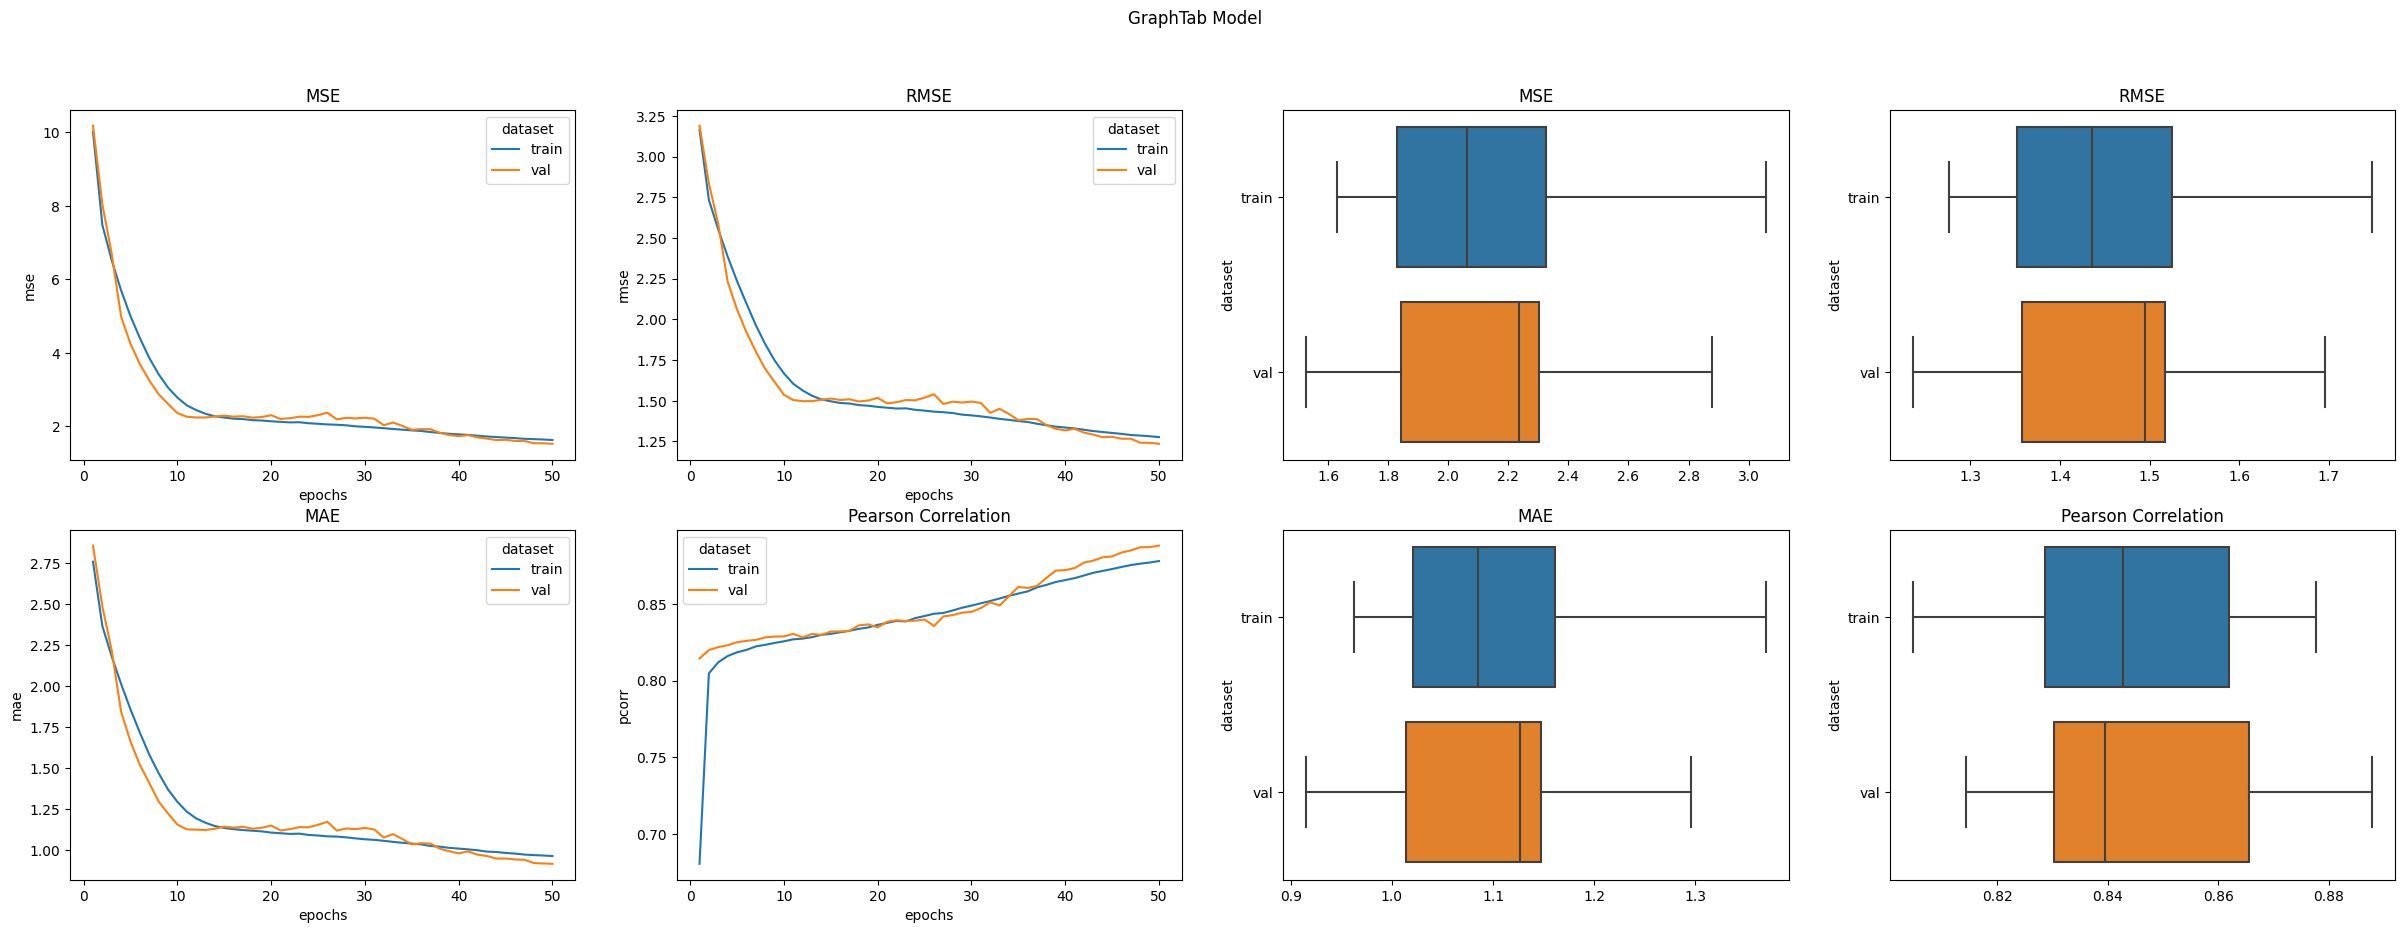

In [64]:
plot_model_results(train_val_per_model['GraphTab'], 'GraphTab')

In [77]:
gt.get('model_state_dict')

OrderedDict([('cell_emb.module_0.att_src',
              tensor([[[-0.0228,  0.0180, -0.0121, -0.1664, -0.0159,  0.0943, -0.0222,
                        -0.0753,  0.0027,  0.0608, -0.0405, -0.0865, -0.0715, -0.0136,
                         0.0648,  0.1219, -0.0074,  0.0617,  0.0829, -0.0704, -0.0478,
                         0.1028,  0.1069,  0.0337, -0.1085,  0.0953, -0.1495,  0.0976,
                        -0.0096,  0.0691, -0.1444, -0.0702,  0.0825,  0.1187, -0.0140,
                         0.1306, -0.0540, -0.0963, -0.0519,  0.0059, -0.0216,  0.0912,
                        -0.0943, -0.0341, -0.1597,  0.1247, -0.0560, -0.1019, -0.0253,
                         0.0037,  0.0627, -0.0315,  0.0839, -0.0737, -0.0353, -0.0254,
                         0.0322,  0.1082, -0.0087,  0.1034,  0.1149, -0.0922, -0.0003,
                        -0.0711,  0.0684, -0.0520,  0.0610, -0.0009, -0.1204, -0.0896,
                        -0.1570, -0.0998,  0.0482,  0.0264,  0.1253, -0.1363,  0.0160,


In [81]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

with open('../../data/processed/' + 'gdsc2_drm.pkl', 'rb') as f: 
    drm = pickle.load(f)
with open('../../data/processed/gdsc2/990/' + f'thresh_gdsc2_990_gene_graphs.pkl', 'rb') as f: 
    cl = pickle.load(f)
with open('../../data/processed/gdsc2/' + f'gdsc2_smiles_dict.pkl', 'rb') as f:
    smiles = pickle.load(f)   

model = get_data_for_model_validation(
    gt, 
    create_graph_tab_datasets,
    GraphTab_v2, 
    BuildGraphTabModel,
    drm, 
    cl, 
    smiles,
    seed,
    'GraphTab'
)

Full     shape: (137835, 9)
train    shape: (110268, 9)
test_val shape: (27567, 9)
test     shape: (13783, 9)
val      shape: (13784, 9)
train_dataset:
GraphTabDataset Summary
# observations : 110268
# cell-lines   : 856
# drugs        : 181
# genes        : 293
test_dataset:
GraphTabDataset Summary
# observations : 13783
# cell-lines   : 856
# drugs        : 181
# genes        : 293
val_dataset:
GraphTabDataset Summary
# observations : 13784
# cell-lines   : 856
# drugs        : 181
# genes        : 293


In [82]:
test_res, ic50s = calculate_and_return_metrics(model, test_res, ic50s, 'GraphTab')

Iteration (val): 100%|██████████| 14/14 [00:02<00:00,  6.83it/s]


                mse     rmse       mae        r2       pcc       scc
----------  -------  -------  --------  --------  --------  --------
train       1.44654  1.20272  0.893589  0.796464  0.894495  0.869855
validation  1.52719  1.2358   0.91523   0.784523  0.887855  0.86186
test        1.52199  1.23369  0.909372  0.786434  0.888829  0.865576


### TabGraph

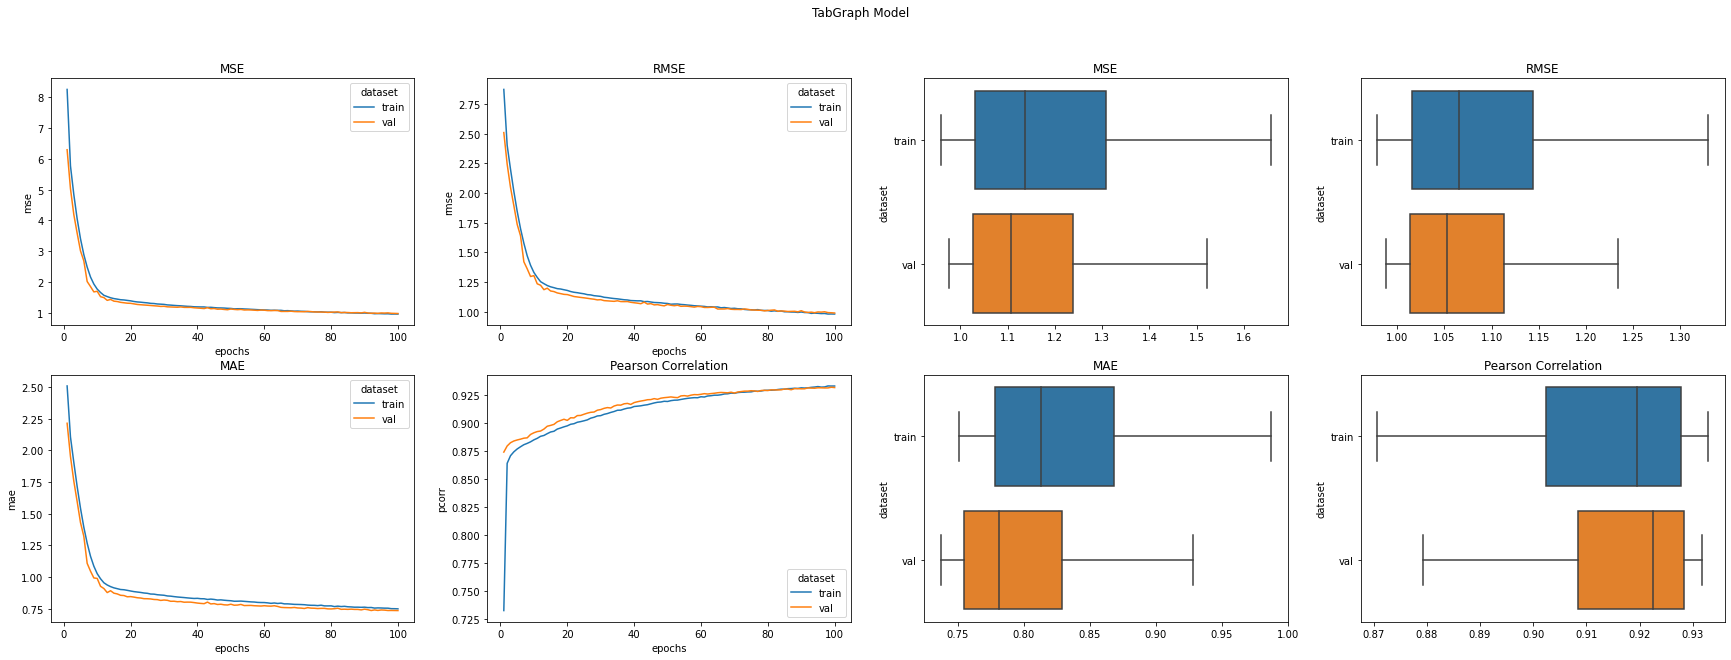

In [15]:
plot_model_results(train_val_per_model['TabGraph'], 'TabGraph')

In [27]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

with open('../../data/processed/' + 'gdsc2_drm.pkl', 'rb') as f: 
    drm = pickle.load(f)
with open('../../data/processed/gdsc2/990/' + f'thresh_gdsc2_990_gene_mat.pkl', 'rb') as f: 
    cl = pickle.load(f)
with open('../../data/processed/gdsc2/' + f'gdsc2_smiles_graphs.pkl', 'rb') as f:
    smiles = pickle.load(f)   
cl.set_index('CELL_LINE_NAME', inplace=True)
    
model = get_data_for_model_validation(
    tg, 
    create_tab_graph_datasets,
    TabGraph_v1, 
    BuildTabGraphModel,
    drm, 
    cl, 
    smiles,
    seed,
    'TabGraph'
)

TypeError: Can't instantiate abstract class TabGraphDataset with abstract methods get, len

In [17]:
test_res, ic50s = calculate_and_return_metrics(model, test_res, ic50s, 'TabGraph')

Iteration (val): 100%|██████████| 14/14 [00:05<00:00,  2.62it/s]

                 mse      rmse       mae        r2       pcc       scc
----------  --------  --------  --------  --------  --------  --------
train       0.750131  0.866101  0.660584  0.894393  0.946019  0.922804
validation  0.976124  0.98799   0.736819  0.862292  0.928834  0.904549
test        0.978758  0.989322  0.735769  0.862838  0.929099  0.908336


### Summary

For the following configurations
- number of epochs: 100
- combined score threshold: 990
- learning rate: 0.0001
- batch size: 1000
- seed: 42

Results for the test set:


In [19]:
test_res.to_csv('../performances/metrics_test_gdsc2_v1_100epochs.csv', index=False)
test_res

,model,mse,rmse,mae,r2,pcc,scc
0,TabTab,0.9352,0.967057,0.71581,0.868427,0.931941,0.911884
1,GraphTab,2.203784,1.484515,1.108914,0.690293,0.841992,0.802662
2,TabGraph,0.978758,0.989322,0.735769,0.862838,0.929099,0.908336


| Model         | MSE    | RMSE       | MAE    | r2         | PCC        | SCC    |
| ------------- | ------ | ---------- | ------ | ---------- | ---------- | ------ |
| TabTab        | 0.9352 | __0.9670__ | 0.7158 | __0.8684__ | __0.9319__ | 0.9118 | 
| GraphTab      | 2.2037 | 1.4845     | 1.1089 | 0.6902     | 0.8419     | 0.8026 | 
| TabGraph      | 0.9787 | 0.9893     | 0.7357 | 0.8628     | 0.9290     | 0.9083 | 
| GraphGraph    | | | | | | | 
| Linear Regr.  | 1.9755 | 6.3872     | 2.5273 | | 0.3167   | 0.3362 | 
| SVM           | | | | | | | 
| Random Forest | 1.9754 | 6.3836     | 2.5265 | | 0.3174   | 0.3372 |
| Drug Mean     | | | | | | |

In [31]:
ic50s.to_csv('../performances/ic50s_test_gdsc2_v1_100epochs.csv', index=False)
print(ic50s.shape)
ic50s.head(5)

(41349, 3)


,model,y_true,y_pred
0,TabTab,0.418922,0.330555
1,TabTab,5.516386,5.494784
2,TabTab,-3.588583,-2.162802
3,TabTab,2.089467,2.717782
4,TabTab,6.036913,5.513148


--- 

## Predicted vs Observed IC50s

In [83]:
ic50s = pd.read_csv('../performances/ic50s_test_gdsc2_v1_100epochs.csv')
print(ic50s.shape)

(41349, 3)


In [21]:
ic50s['y_true'] = ic50s['y_true'].astype(float)
ic50s['y_pred'] = ic50s['y_pred'].astype(float)

sns.set_theme(
    style='ticks', 
    rc={
    'axes.titlesize': PlottingParameters.TITLE_FONTSIZE.value + 3,
    'axes.labelsize': PlottingParameters.XLABEL_FONTSIZE.value + 3,
    'xtick.labelsize': PlottingParameters.XTICKS_LABELSIZE.value + 3,
    'ytick.labelsize': PlottingParameters.YTICKS_LABELSIZE.value + 3,   
});

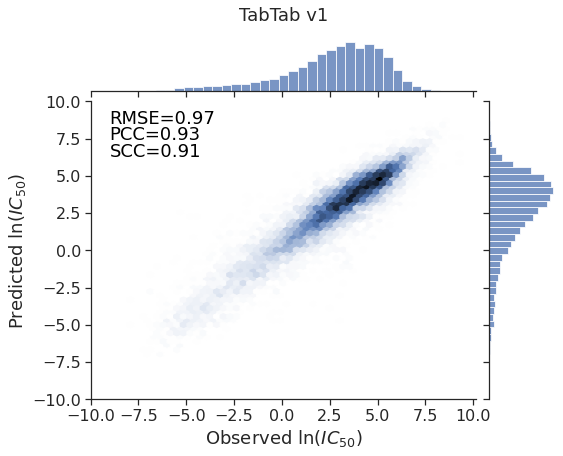

In [28]:
fig_tabtab = plot_observed_vs_predicted_ln_ic50s(
    ic50s.loc[ic50s.model=='TabTab'], 
    test_res.loc[test_res.model=='TabTab', 'rmse'].iloc[0],
    test_res.loc[test_res.model=='TabTab', 'pcc'].iloc[0],
    test_res.loc[test_res.model=='TabTab', 'scc'].iloc[0],      
    model_name='TabTab',
    version='v1'
)    
fig_tabtab.savefig('../performances/imgs/tabtab_v1_990_pred_vs_true_ic50s.svg', bbox_inches='tight')

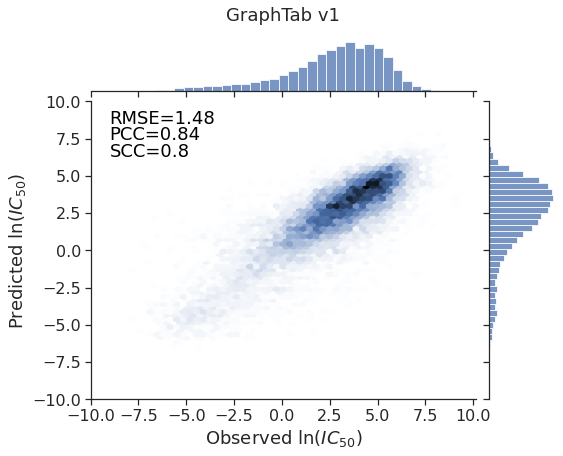

In [29]:
fig_graphtab = plot_observed_vs_predicted_ln_ic50s(
    ic50s.loc[ic50s.model=='GraphTab'], 
    test_res.loc[test_res.model=='GraphTab', 'rmse'].iloc[0],
    test_res.loc[test_res.model=='GraphTab', 'pcc'].iloc[0],
    test_res.loc[test_res.model=='GraphTab', 'scc'].iloc[0],      
    model_name='GraphTab',
    version='v1'
)    
fig_graphtab.savefig('../performances/imgs/graphtab_v1_990_pred_vs_true_ic50s.svg', bbox_inches='tight')

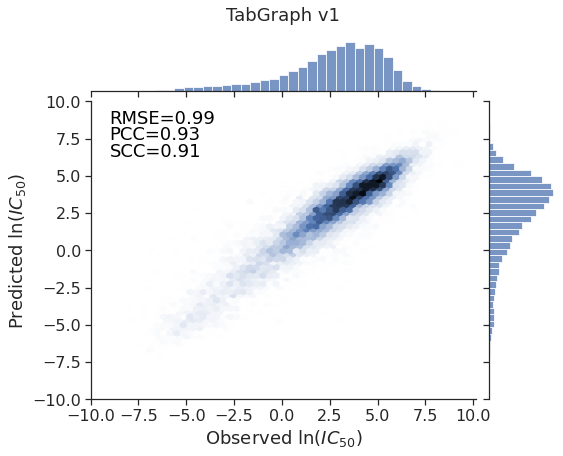

In [30]:
fig_tabgraph = plot_observed_vs_predicted_ln_ic50s(
    ic50s.loc[ic50s.model=='TabGraph'], 
    test_res.loc[test_res.model=='TabGraph', 'rmse'].iloc[0],
    test_res.loc[test_res.model=='TabGraph', 'pcc'].iloc[0],
    test_res.loc[test_res.model=='TabGraph', 'scc'].iloc[0],    
    model_name='TabGraph',
    version='v1'
)    
fig_tabgraph.savefig('../performances/imgs/tabgraph_v1_990_pred_vs_true_ic50s.svg', bbox_inches='tight')

- [ ] Do the above plots for the lnic50 values divided by the drug-mean as well

---

## GNNExplainer

- [PyTorch doc](https://pytorch-geometric.readthedocs.io/en/latest/modules/explain.html?highlight=GNNExplainer#torch_geometric.explain.algorithm.GNNExplainer)
- [PyTorch code example](https://github.com/pyg-team/pytorch_geometric/blob/master/examples/gnn_explainer.py)

<ins>Notes:</ins>
- falls into the category of perturbation-based methods.
- consists of learning soft masks for edges and node features.
- to do so it starts by randomly initializing soft masks and combining them with the original graph via element-wise multiplications.
- then, the masks are optimized by maximizing the mutual information between the predictions of the original graph and the predictions of the newly obtained graph.

__Notes__:

- [GNNExplainer from version 2.0.3](https://pytorch-geometric.readthedocs.io/en/2.0.3/_modules/torch_geometric/nn/models/gnn_explainer.html) is the latest version where `visualize_subgraph` can be used

In [90]:
from torch_geometric.explain.algorithm import GNNExplainer

### GraphTab

In [91]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

with open('../../data/processed/' + 'gdsc2_drm.pkl', 'rb') as f: 
    drm = pickle.load(f)
with open('../../data/processed/gdsc2/990/' + f'thresh_gdsc2_990_gene_graphs.pkl', 'rb') as f: 
    cl = pickle.load(f)
with open('../../data/processed/gdsc2/' + f'gdsc2_smiles_dict.pkl', 'rb') as f:
    smiles = pickle.load(f)   

model = get_data_for_model_validation(
    gt, 
    create_graph_tab_datasets,
    GraphTab_v2, 
    BuildGraphTabModel,
    drm, 
    cl, 
    smiles,
    seed,
    'GraphTab'
)

Full     shape: (137835, 9)
train    shape: (110268, 9)
test_val shape: (27567, 9)
test     shape: (13783, 9)
val      shape: (13784, 9)
train_dataset:
GraphTabDataset Summary
# observations : 110268
# cell-lines   : 856
# drugs        : 181
# genes        : 293
test_dataset:
GraphTabDataset Summary
# observations : 13783
# cell-lines   : 856
# drugs        : 181
# genes        : 293
val_dataset:
GraphTabDataset Summary
# observations : 13784
# cell-lines   : 856
# drugs        : 181
# genes        : 293


In [27]:
model.val_loader.dataset.cell_lines.head(5)

0     CHSA8926
1    RPMI-8402
2        SW837
3       WM793B
4      NCI-H82
Name: CELL_LINE_NAME, dtype: object

In [28]:
model.val_loader.dataset.drug_ids.head(5)

0    1250
1    1049
2    1564
3    1067
4    1916
Name: DRUG_ID, dtype: int64

In [29]:
#model.val_loader.dataset[0] # gives cell-line graph for cell line CHSA8926, and SMILES string for drug 1250 and the corresponding ic50 value.

In [30]:
model.val_loader.dataset.cell_line_graphs.get('MOG-G-CCM').batch

In [31]:
for i, data in enumerate(model.val_loader):
    cell, drug, ic50s = data
    print(cell.batch)
    print(torch.stack(drug, 0).transpose(1, 0).float())
    print(torch.stack(drug, 0).transpose(1, 0).float().shape)
    break

tensor([  0,   0,   0,  ..., 999, 999, 999])
tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 1.]])
torch.Size([1000, 256])


In [32]:
torch.tensor([0])

tensor([0])

In [102]:
# --- Example cell-line drug combination ---
idx = 0
cl_drug_combi = model.val_loader.dataset[idx]
print(f"Testing for combination\n"\
      f"   cell-line: {model.val_loader.dataset.cell_lines[idx]}\n" \
      f"   drug     : {model.val_loader.dataset.drug_ids[idx]}")
G = cl_drug_combi[0]
drug = cl_drug_combi[1]
ic50 = cl_drug_combi[2]
G.y = ic50
print(G.x.shape)
print(G.edge_index.shape)
print(G)
print(len(drug))
print(ic50)
print(G.batch)

Testing for combination
   cell-line: CHSA8926
   drug     : 1250
torch.Size([293, 4])
torch.Size([2, 874])
Data(x=[293, 4], edge_index=[2, 874], y=1.287589)
256
1.287589
None


In [34]:
G.edge_index

tensor([[268, 222, 151,  ...,   1, 197, 194],
        [186, 247, 214,  ..., 221, 143, 114]])

In [35]:
print(torch.tensor(drug).float().reshape(1,256).shape)
torch.tensor(drug).float().reshape(1,256)

torch.Size([1, 256])


tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
         0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
         0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
         1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
         0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1.,
         0., 0., 0., 0., 0.,

In [36]:
from torch_geometric.explain import Explainer, GNNExplainer
# from torch_geometric.nn import GNNExplainer

explainer = Explainer(
    model=model.model,
    algorithm=GNNExplainer(epochs=200),
    explainer_config=dict(
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object',        
    ),
    model_config=dict(
        mode='regression',
        task_level='graph',
        return_type='raw'
    )
)

In [37]:
explanation = explainer(
    G.x,
    G.edge_index,
    cell_batch=torch.tensor([0]),
    drug=torch.tensor(drug).double().reshape(1, 256)
)

TypeError: GraphTab_v2.forward() got an unexpected keyword argument 'x'

In [99]:
from torch_geometric.explain.algorithm import GNNExplainer

# --- Initialize Explainer ---
model.model.double()
gnn_explainer = GNNExplainer(
    model=model.model,
    epochs=100,
    return_type='regression',
    nhops=2
)

In [251]:
from torch_geometric.explain import Explainer, GNNExplainer

#     x=G.x, 
#     edge_index=G.edge_index,
#     cell_batch=torch.tensor([0]),
#     drug=torch.tensor(drug).double().reshape(1, 256)

model.model.to('cpu')

explainer = Explainer(
    model=model.model,
    algorithm=GNNExplainer(epochs=200,
                           return_type='regression',
                           nhops=2,
                           return_mask=True),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='graph'
    ),
)

G.to('cpu')
# drug.to('cpu')

node_index = 0
explanation = explainer(G.x, 
                        G.edge_index, 
                        cell_batch=torch.tensor([0]),
                        drug=torch.tensor(drug).double().reshape(1, 256),
                        index=node_index
                        )
print(f'Generated explanations in {explanation.available_explanations}')

path = 'feature_importance.png'
explanation.visualize_feature_importance(path, 
                                         feat_labels=['GExpr', 'CnvG', 'CnvP', 'Mut'],
                                         top_k=10)
print(f"Feature importance plot has been saved to '{path}'")

path = 'subgraph.pdf'
explanation.visualize_graph(path)
print(f"Subgraph visualization plot has been saved to '{path}'")

Generated explanations in ['edge_mask', 'node_mask']
Feature importance plot has been saved to 'feature_importance.png'
Subgraph visualization plot has been saved to 'subgraph.pdf'


In [116]:
G.x

tensor([[3.9390, 0.0000, 2.0000, 0.0000],
        [7.7586, 0.0000, 2.0000, 1.0000],
        [3.5385, 0.0000, 2.0000, 0.0000],
        ...,
        [3.4511, 1.0000, 3.0000, 0.0000],
        [4.6699, 0.0000, 2.0000, 0.0000],
        [8.5540, 0.0000, 2.0000, 0.0000]], dtype=torch.float64)

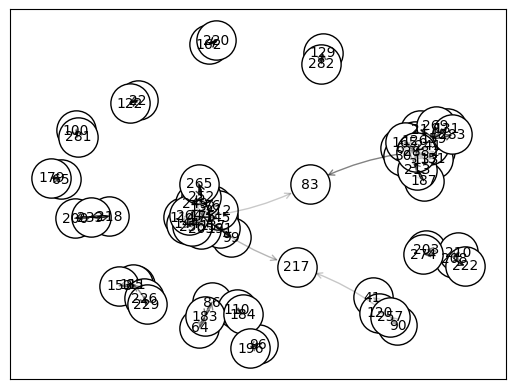

In [252]:
import torch
torch.manual_seed(123)

explanation = explainer(G.x, 
                        G.edge_index, 
                        cell_batch=torch.tensor([0]),
                        drug=torch.tensor(drug).double().reshape(1, 256)
#                         index=0
                        )

explanation.visualize_graph()

In [244]:
G.edge_index

tensor([[268, 222, 151,  ...,   1, 197, 194],
        [186, 247, 214,  ..., 221, 143, 114]])

In [248]:
G.edge_index[:, 85]

tensor([213, 288])

In [250]:
# Get the GENE_SYMBOL's of the main important edge.
gene_mapping = pd.read_csv('../../data/processed/sparse_inter_genes.csv')
gene_mapping[gene_mapping.GENE_INDEX.isin([213, 288])]

,GENE_SYMBOL,GENE_INDEX
213,MAN2B1,213
288,RFC2,288


> The `edge_mask` in _GNNExplainer_ is a tensor of shape `(num_edges,)` representing the importance score of each edge in the input graph.

- It is calculated by computing the difference between the GNN's output on the original graph and the GNN's output on a randomly perturbed version of the graph. 
- The larger the absolute value of an edge's score, the more important it is for the GNN's prediction.
- In other words, the edge_mask tells us which edges in the input graph are most important for the GNN's prediction. 
- This information can be used to visualize subgraphs or to identify important features in the graph.

In [191]:
gene_mapping = pd.read_csv('../../data/processed/sparse_inter_genes.csv')

# Get the edge mask tensor
edge_mask = explanation.edge_mask

# Select the top-k most important edges (genes)
k = 10
topk_values, topk_indices = torch.topk(edge_mask, k, largest=True)
topk_genes = gene_mapping[gene_mapping.GENE_INDEX.isin(topk_indices.tolist())]
topk_genes.insert(loc=2, column='values', value=[None] * len(topk_values))
for i, v in zip(topk_indices, topk_values):
    topk_genes.loc[i.item(), 'values'] = v.item()

# Print the indices of the top-k most important edges (genes)
print(f"Top-{k} most important genes:")
topk_genes

Top-10 most important genes:


,GENE_SYMBOL,GENE_INDEX,values
179,TRAM2,179,0.775041
214,ARL4C,214,0.770122
359,PTGS2,359,0.708493
396,NR2F6,396,0.808171
449,TUBB6,449,0.70107
453,RRAGA,453,0.791214
502,APP,502,0.711843
577,TM9SF2,577,0.720463
649,LSR,649,0.699656
685,CDC25A,685,0.747


In [159]:
torch.topk(edge_mask, k, largest=True)

torch.return_types.topk(
values=tensor([0.8082, 0.7912, 0.7750, 0.7701, 0.7470, 0.7205, 0.7118, 0.7085, 0.7011,
        0.6997]),
indices=tensor([396, 453, 179, 214, 685, 577, 502, 359, 449, 649]))

In [205]:
k = 20
topk_values, topk_indices = torch.topk(edge_mask, k, largest=True)
topk_genes = gene_mapping[gene_mapping.GENE_INDEX.isin(topk_indices.tolist())]
for i in topk_indices.tolist():
    print(f"i: {i}  is in --> {[i in list(gene_mapping.GENE_INDEX.values)]}")

i: 396  is in --> [True]
i: 453  is in --> [True]
i: 179  is in --> [True]
i: 214  is in --> [True]
i: 685  is in --> [True]
i: 577  is in --> [True]
i: 502  is in --> [True]
i: 359  is in --> [True]
i: 449  is in --> [True]
i: 649  is in --> [True]
i: 332  is in --> [True]
i: 488  is in --> [True]
i: 684  is in --> [True]
i: 859  is in --> [False]
i: 754  is in --> [True]
i: 106  is in --> [True]
i: 699  is in --> [True]
i: 652  is in --> [True]
i: 628  is in --> [True]
i: 495  is in --> [True]


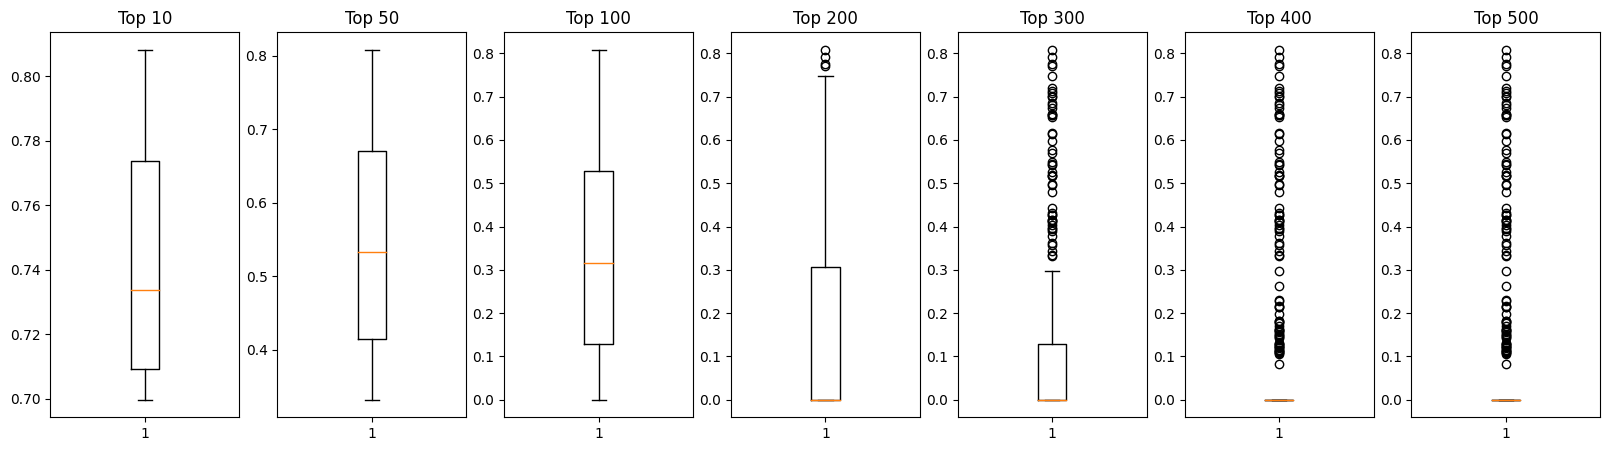

In [243]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 7, figsize=(20, 5))

# Create the first boxplot
for i, k in enumerate([10, 50, 100, 200, 300, 400, 500]):
    topk_values, topk_indices = torch.topk(edge_mask, k, largest=True)
    axs[i].boxplot(topk_values); axs[i].set_title(f"Top {k}")

# Display the plot
plt.show()

Generated explanations in ['edge_mask', 'node_mask']


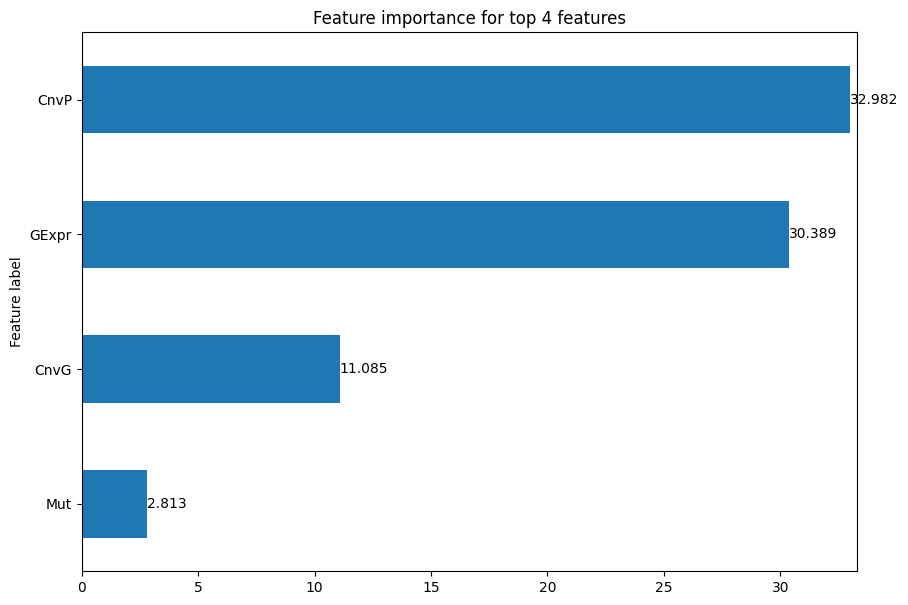

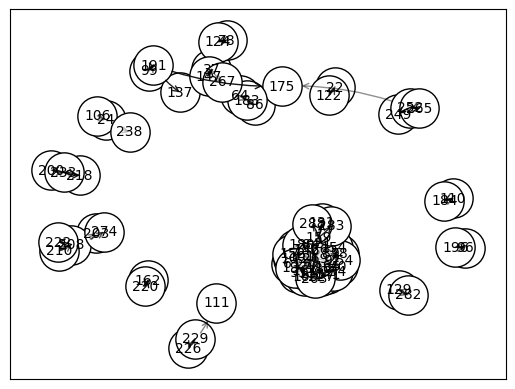

In [283]:
from torch_geometric.explain import Explainer, GNNExplainer

model.model.to('cpu')

explainer = Explainer(
    model=model.model,
    algorithm=GNNExplainer(epochs=200,
                           return_type='regression',
                           nhops=2,
                           return_mask=True),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='graph',
        return_type='raw'
    ),
)

G.to('cpu')

node_index = 0
explanation = explainer(G.x, 
                        G.edge_index, 
                        cell_batch=torch.tensor([0]),
                        drug=torch.tensor(drug).double().reshape(1, 256),
                        index=node_index
                        )
print(f'Generated explanations in {explanation.available_explanations}')

explanation.visualize_feature_importance(feat_labels=['GExpr', 'CnvG', 'CnvP', 'Mut'],
                                         top_k=10)

explanation.visualize_graph()

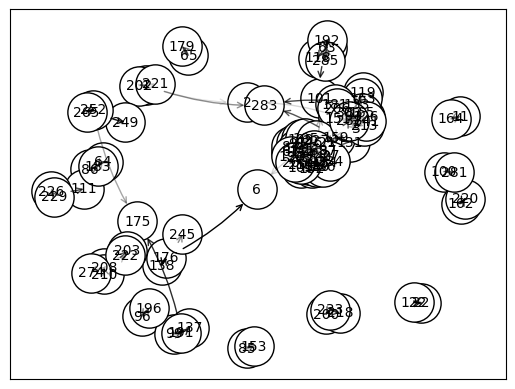

In [271]:
explanation.visualize_graph()

In [272]:
from torch_geometric.nn.models.expl 

ModuleNotFoundError: No module named 'torch_geometric.nn.models.explainer'

### TabGraph

In [43]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

with open('../../data/processed/' + 'gdsc2_drm.pkl', 'rb') as f: 
    drm = pickle.load(f)
with open('../../data/processed/gdsc2/990/' + f'thresh_gdsc2_990_gene_mat.pkl', 'rb') as f: 
    cl = pickle.load(f)
with open('../../data/processed/gdsc2/' + f'gdsc2_smiles_graphs.pkl', 'rb') as f:
    smiles = pickle.load(f)   
cl.set_index('CELL_LINE_NAME', inplace=True)
    
model = get_data_for_model_validation(
    tg, 
    create_tab_graph_datasets,
    TabGraph_v1, 
    BuildTabGraphModel,
    drm, 
    cl, 
    smiles,
    seed,
    'TabGraph'
)

In [44]:
model.val_loader.dataset.drug_ids[:10]

0    1250
1    1049
2    1564
3    1067
4    1916
5    1093
6    1038
7    1021
8    1614
9    1915
Name: DRUG_ID, dtype: int64

In [58]:
# Initialize Explainer.
explainer = GNNExplainer(
    model=model.model,
    epochs=2,
    return_type='regression',
#     feat_mask_type='feature',
#     allow_edge_mask=True,
    nhops=2
)

In [69]:
for data in model.val_loader:
    cell, drug, ic50 = data
    drug.y = ic50
    print(drug)
    break
G = drug
print(G.x.shape)
print(G.edge_index.shape)
print(G.y[:10])

DataBatch(x=[31294, 9], edge_index=[2, 68772], edge_attr=[68772, 3], smiles=[1000], batch=[31294], ptr=[1001], y=[1000])
torch.Size([31294, 9])
torch.Size([2, 68772])
tensor([-0.5597, -2.9528,  5.2254,  3.2985,  0.4312, -4.6706, -1.9874,  3.9925,
        -2.9445,  4.7274])


In [72]:
torch.stack(cell, 0).transpose(1, 0).float()

tensor([[3.7786, 8.3231, 3.2138,  ..., 0.0000, 0.0000, 0.0000],
        [3.7870, 9.1227, 3.2696,  ..., 0.0000, 0.0000, 0.0000],
        [3.6516, 6.9799, 3.0286,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [3.7704, 9.2162, 4.1082,  ..., 0.0000, 0.0000, 0.0000],
        [3.9622, 7.9626, 4.1039,  ..., 0.0000, 0.0000, 1.0000],
        [3.7641, 8.0261, 3.2946,  ..., 0.0000, 0.0000, 0.0000]])

In [67]:
# Explain node.
node_idx = 2
node_feat_mask, edge_mask = explainer.explain_node(
    node_idx, 
    G.x,
    G.edge_index,
    cell=torch.stack(cell, 0).transpose(1, 0).float(),
    drug=drug
)

TypeError: TabGraph_v1.forward() got multiple values for argument 'cell'

In [56]:
G = model.val_loader.dataset.drug_graphs[1049]
print(G.x.shape)
print(G.edge_index.shape)

torch.Size([38, 9])
torch.Size([2, 80])


In [57]:
G

Data(x=[38, 9], edge_index=[2, 80], edge_attr=[80, 3], smiles='CCN(CC)CCCCN=c1ncc2cc(c3cc(cc(c3)OC)OC)c(nc2[nH]1)N=C(NC(C)(C)C)O')

In [55]:
# Explain node.
node_idx = 2
node_feat_mask, edge_mask = explainer.explain_node(
    node_idx, 
    G.x,
    G.edge_index,
    
)

RuntimeError: mat1 and mat2 must have the same dtype

In [226]:
model.val_loader.dataset.drug_graphs[1003].x

tensor([[6, 0, 4, 5, 3, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 1, 4, 5, 0, 0, 4, 0, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [7, 0, 2, 5, 0, 0, 3, 1, 1],
        [6, 0, 4, 5, 2, 0, 4, 0, 1],
        [7, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [8, 0, 1, 5, 0, 0, 3, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 4, 5, 2, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 3, 0, 1],
        [6, 0, 3, 5, 0, 0, 3, 0, 1],
        [8, 0, 1, 5, 0, 0, 3, 0, 0],
        [8, 0, 2, 5, 1, 0, 4, 0, 0]])

In [228]:
model.val_loader.dataset.drug_graphs[1003].edge_index

tensor([[ 0,  1,  1,  2,  2,  2,  2,  3,  3,  3,  4,  4,  5,  5,  5,  6,  6,  6,
          7,  7,  7,  8,  8,  9,  9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14,
         14, 15, 15, 16, 16, 17, 17, 17, 18, 18, 18, 19, 20, 20, 20, 21, 21, 22,
         22, 23, 23, 23, 24, 25],
        [ 1,  0,  2,  1,  3, 23, 25,  2,  4, 20,  3,  5,  4,  6, 17,  5,  7, 15,
          6,  8, 16,  7,  9,  8, 10, 14,  9, 11, 10, 12, 11, 13, 12, 14,  9, 13,
         15,  6, 14,  7, 17,  5, 16, 18, 17, 19, 20, 18,  3, 18, 21, 20, 22, 21,
         23,  2, 22, 24, 23,  2]])

In [229]:
model.val_loader.dataset.drug_graphs[1003]

Data(x=[26, 9], edge_index=[2, 60], edge_attr=[60, 3], smiles='CC[C@@]1(c2cc3c4c(cc5ccccc5n4)Cn3c(=O)c2COC1=O)O')

In [ ]:
x, edge_i, edge_t = graph_data.x_user, graph_data.edge_index_user, graph_data.edge_type_user
xi, edge_ii, edge_ti = graph_data.x_item, graph_data.edge_index_item, graph_data.edge_type_item

explainer.explain_graph(
    x=x, 
    edge_index=edge_index, 
    edge_type_user=edge_type, 
    x_item=xi, 
    edge_index_item=edge_indexi, 
    edge_type_item=edge_typei
)

In [239]:
for data in model.val_loader:
    cell, drug, ic50s = data
    print(len(cell))
    print(drug)
    break

1172
DataBatch(x=[31541, 9], edge_index=[2, 69244], edge_attr=[69244, 3], smiles=[1000], batch=[31541], ptr=[1001])


In [248]:
drug

DataBatch(x=[31541, 9], edge_index=[2, 69244], edge_attr=[69244, 3], smiles=[1000], batch=[31541], ptr=[1001])

In [251]:
torch.stack(cell, 0).transpose(1, 0)

tensor([[3.7427, 7.8459, 3.4596,  ..., 0.0000, 0.0000, 0.0000],
        [3.8839, 8.4314, 3.5929,  ..., 0.0000, 0.0000, 0.0000],
        [5.0053, 8.9406, 3.1268,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [5.4157, 8.8205, 3.6573,  ..., 0.0000, 1.0000, 0.0000],
        [3.9901, 8.5271, 3.8902,  ..., 0.0000, 0.0000, 0.0000],
        [3.5029, 8.3078, 3.3360,  ..., 0.0000, 0.0000, 0.0000]])

In [279]:
temp = model.val_loader.dataset.drug_graphs[1003]

explainer.explain_graph(
    x=drug.x,
    edge_index=drug.edge_index,
    drug=1 #torch.stack(cell, 0).transpose(1, 0)
)

TypeError: TabGraph_v1.forward() got multiple values for argument 'drug'

In [221]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Explainer, GNNExplainer
from torch_geometric.nn import GCNConv

dataset = 'Cora'
dataset = Planetoid('hallo', dataset)
data = dataset[0]

Processing...
Done!


In [222]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [225]:
dataset[0]

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

# Predicted vs Actual LN_IC50

In [1]:
import sys
import os
import pickle
import random
import torch
import torch.nn as nn
import tqdm as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sys.path.append('/home/ec2-user/SageMaker/projects/gnn/GNN-material/src')
sys.path = list(set(sys.path))

from sklearn.model_selection import train_test_split
from models.GraphTab.graph_tab_early_stopping import GraphTabDataset, create_gt_loaders, BuildGraphTabModel, GraphTab
from models.GraphGraph.graph_graph_early_stopping import GraphGraphDataset, create_gg_loaders, BuildGraphGraphModel, GraphGraph

/home/ec2-user/anaconda3/envs/gnn2803/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def plot_observed_vs_predicted_ln_ic50s(ic50s: pd.DataFrame, 
                                        rmse: float,
                                        pcc: float,
                                        scc: float,
                                        title: str):
    """Plot the observed ln(IC50) value against the predicted ones."""
    ax = sns.jointplot(x='y_true', y='y_pred', data=ic50s, kind='hex',
                       marginal_kws={'bins': 35});
    ax.fig.set_size_inches(8, 6);

    plt.xlabel(r'Observed $\ln(IC_{50})$');
    plt.ylabel(r'Predicted $\ln(IC_{50})$');
    plt.xticks(np.arange(-10, 11, 2.5));
    plt.yticks(np.arange(-10, 11, 2.5));

    plt.text(-9, 8.5, 
             f"RMSE={round(rmse, 2)}", 
             horizontalalignment='left', size=18, color='black');
    plt.text(-9, 7.4, 
             f"PCC={round(pcc, 2)}", 
             horizontalalignment='left', size=18, color='black');
    plt.text(-9, 6.3, 
             f"SCC={round(scc, 2)}", 
             horizontalalignment='left', size=18, color='black');    

    plt.title(f'{title}', y=1.25);
    plt.show();
    
    return ax.fig

## GraphGraph

In [82]:
path_to_drm = '../../data/processed/gdsc2/gdsc2_drm.pkl'
path_to_gene_graphs = '../../data/processed/gdsc2/990/thresh_gdsc2_990_gene_graphs.pkl'
path_to_simles_graphs = '../../data/processed/gdsc2/gdsc2_smiles_graphs.pkl'
path_to_fps = '../../data/processed/gdsc2/gdsc2_smiles_dict.pkl'

with open(path_to_drm, 'rb') as f: 
    drm = pickle.load(f)
    print(f"Finished reading drug response matrix: {drm.shape}")

with open(path_to_gene_graphs, 'rb') as f:
    cl_graphs = pd.read_pickle(f)
    print(f"Finished reading cell-line graphs: {cl_graphs['22RV1']}")
# Read drug smiles graphs.
with open(path_to_simles_graphs, 'rb') as f: 
    drug_graphs = pickle.load(f)
    print(f"Finished reading drug SMILES graphs: {drug_graphs[1003]}")
    
with open(path_to_fps, 'rb') as f:
    fingerprints_dict = pickle.load(f)    

Finished reading drug response matrix: (137835, 9)
Finished reading cell-line graphs: Data(x=[293, 4], edge_index=[2, 874])
Finished reading drug SMILES graphs: Data(x=[26, 9], edge_index=[2, 60], edge_attr=[60, 3], smiles='CC[C@@]1(c2cc3c4c(cc5ccccc5n4)Cn3c(=O)c2COC1=O)O')


In [83]:
import torch
import argparse

# Load the model.
model_trained = torch.load(
    '../performances/grid_experiments/model_performance_GraphGraph_v1_gdsc2_990_42_GCNConv_2Gin990max150.pth', 
    map_location=torch.device('cpu')
)

# Simulate arguments.
parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', type=int, default=128, help='the batch size (default: 10)')
parser.add_argument('--num_workers', type=int, default=1, help='number of workers for DataLoader (default: 4)')
args, unknown = parser.parse_known_args()
print(args)

graph_tab_dataset = GraphGraphDataset(
    cl_graphs, 
    drug_graphs, 
    drm
)
print("Finished building GraphGraphDataset!")

drm_train, drm_test = train_test_split(
    drm, 
    test_size=model_trained.get('test_ratio'),
    random_state=42,
    stratify=drm['CELL_LINE_NAME']
)

train_loader, test_loader = create_gg_loaders(
    drm_train,
    drm_test,
    cl_graphs,
    drug_graphs,
    args
)

device = torch.device("cpu")
print(f"Device: {device}")

model_temp = GraphGraph(
    dropout=0.1,
    conv_type='GCNConv',
    conv_layers=2
)    

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(
    params=model_temp.parameters(), 
    lr=model_trained.get('learning_rate'),
    weight_decay=0.0
) 

model = BuildGraphGraphModel(
    model=model_temp, 
    criterion=loss_func, 
    optimizer=optimizer,
    num_epochs=model_trained.get('num_epochs'), 
    train_loader=train_loader,
    test_loader=test_loader,
    early_stopping_threshold=model_trained.get('early_stopping_thresh'),            
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)
print("Finished BuildGraphGraphModel()")

model_state_dict = model_trained.get('model_state_dict')
# model_state_dict = {k: v.to(device) for k, v in model_state_dict.items()}
for key in model_state_dict:
    model_state_dict[key] = model_state_dict[key].to(torch.device('cpu'))
    
model.device = device

model.model.load_state_dict(model_state_dict)
model.model.to(device)

mse, rmse, mae, r2, pcc, scc, y_true, y_pred  = model.validate(test_loader)
print(f"Test  | MSE: {mse} | RMSE: {rmse} | MAE: {mae} | R2: {r2} | PCC: {pcc} | SCC: {scc}")   

Namespace(batch_size=128, num_workers=1)
Finished building GraphGraphDataset!
Device: cpu
Finished BuildGraphGraphModel()


Iteration (val): 100%|██████████| 216/216 [00:31<00:00,  6.85it/s]

Test  | MSE: 0.9729244709014893 | RMSE: 0.9863693118095398 | MAE: 0.7339352965354919 | R2: 0.8631714259355273 | PCC: 0.9290925647482512 | SCC: 0.90687316074543


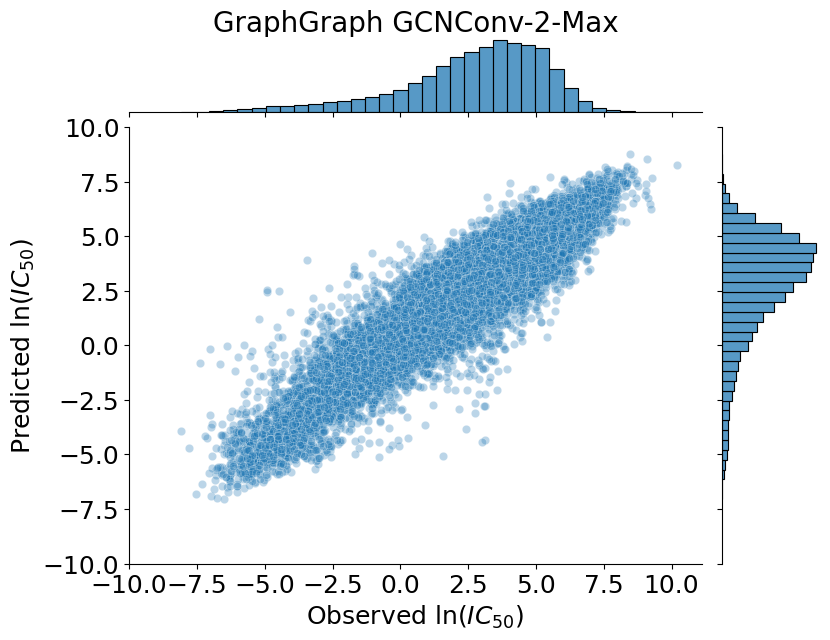

In [40]:
ic50s = pd.DataFrame({
    'y_true': [y[0] for y in y_true.tolist()],
    'y_pred': [y[0] for y in y_pred.tolist()]
})

ax = sns.jointplot(x='y_true', y='y_pred', data=ic50s, 
                   joint_kws={'alpha': 0.3},
                   marginal_kws={'bins': 35});
ax.fig.set_size_inches(8, 6);

plt.xlabel(r'Observed $\ln(IC_{50})$', fontsize=18);
plt.ylabel(r'Predicted $\ln(IC_{50})$', fontsize=18);
plt.xticks(np.arange(-10, 11, 2.5), fontsize=18);
plt.yticks(np.arange(-10, 11, 2.5), fontsize=18); 

plt.title(f'GraphGraph GCNConv-2-Max', y=1.20, fontsize=20);

ax.fig.savefig(f'outputs/GraphGraph_GCNConv_2_Max.png', dpi=300)

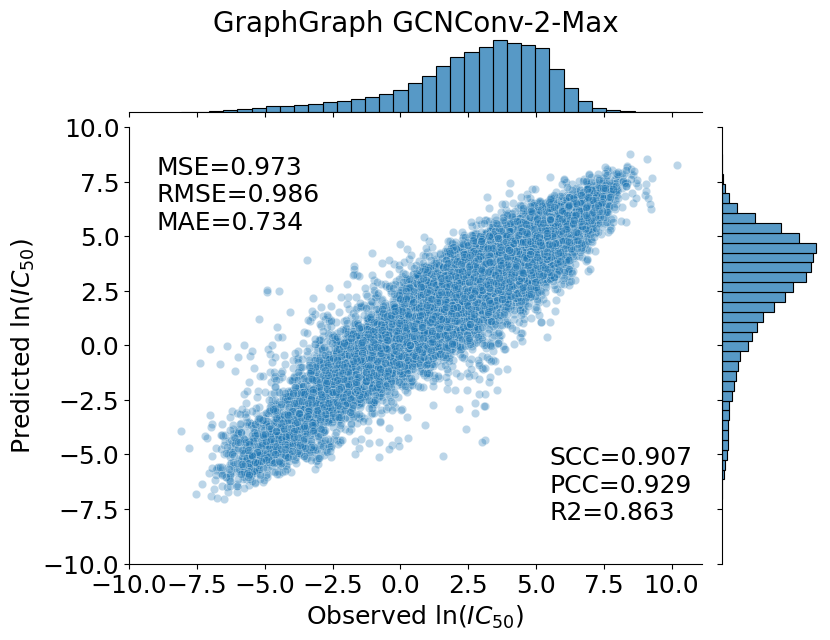

In [84]:
ic50s = pd.DataFrame({
    'y_true': [y[0] for y in y_true.tolist()],
    'y_pred': [y[0] for y in y_pred.tolist()]
})

ax = sns.jointplot(x='y_true', y='y_pred', data=ic50s, 
                   joint_kws={'alpha': 0.3},
                   marginal_kws={'bins': 35});
ax.fig.set_size_inches(8, 6);

plt.xlabel(r'Observed $\ln(IC_{50})$', fontsize=18);
plt.ylabel(r'Predicted $\ln(IC_{50})$', fontsize=18);
plt.xticks(np.arange(-10, 11, 2.5), fontsize=18);
plt.yticks(np.arange(-10, 11, 2.5), fontsize=18); 

plt.title(f'GraphGraph GCNConv-2-Max', y=1.20, fontsize=20);

plt.text(-9, 5.3, 
         f"MSE={mse.item():0.3f}\n" + \
         f"RMSE={rmse.item():0.3f}\n" + \
         f"MAE={mae.item():0.3f}",
         horizontalalignment='left', size=18, color='black');

plt.text(5.5, -8.0, 
         f"SCC={scc:0.3f}\n" + \
         f"PCC={pcc:0.3f}\n" + \
         f"R2={r2:0.3f}", 
         horizontalalignment='left', size=18, color='black');

ax.fig.savefig(f'outputs/GraphGraph_GCNConv_2_Max_with_metrics.png', dpi=300)

## GraphTab

In [42]:
path_to_drm = '../../data/processed/gdsc2/gdsc2_drm.pkl'
path_to_gene_graphs = '../../data/processed/gdsc2/990/thresh_gdsc2_990_gene_graphs.pkl'
path_to_fps = '../../data/processed/gdsc2/gdsc2_smiles_dict.pkl'

with open(path_to_drm, 'rb') as f: 
    drm = pickle.load(f)
    print(f"Finished reading drug response matrix: {drm.shape}")

with open(path_to_gene_graphs, 'rb') as f:
    cl_graphs = pd.read_pickle(f)
    print(f"Finished reading cell-line graphs: {cl_graphs['22RV1']}")
    
with open(path_to_fps, 'rb') as f:
    fingerprints_dict = pickle.load(f)    

Finished reading drug response matrix: (137835, 9)
Finished reading cell-line graphs: Data(x=[293, 4], edge_index=[2, 874])


In [45]:
import torch
import argparse

# Load the model.
model_trained = torch.load(
    '../performances/grid_experiments/model_performance_GraphTab_v1_gdsc2_990_42_GCNConv_Gcn3Gin990Max150.pth', 
    map_location=torch.device('cpu')
)

# Simulate arguments.
parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', type=int, default=128, help='the batch size (default: 10)')
parser.add_argument('--num_workers', type=int, default=1, help='number of workers for DataLoader (default: 4)')
args, unknown = parser.parse_known_args()
print(args)

graph_tab_dataset = GraphTabDataset(
    cl_graphs, 
    fingerprints_dict, 
    drm
)
print("Finished building GraphTabDataset!")

drm_train, drm_test = train_test_split(
    drm, 
    test_size=model_trained.get('test_ratio'),
    random_state=42,
    stratify=drm['CELL_LINE_NAME']
)

train_loader, test_loader = create_gt_loaders(
    drm_train,
    drm_test,
    cl_graphs,
    fingerprints_dict,
    args
)

device = torch.device("cpu")
print(f"Device: {device}")

model_temp = GraphTab(
    dropout=0.1,
    conv_type='GCNConv',
    conv_layers=3
)    

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(
    params=model_temp.parameters(), 
    lr=model_trained.get('learning_rate'),
    weight_decay=0.0
) 

model = BuildGraphTabModel(
    model=model_temp, 
    criterion=loss_func, 
    optimizer=optimizer,
    num_epochs=model_trained.get('num_epochs'), 
    train_loader=train_loader,
    test_loader=test_loader,
    early_stopping_threshold=model_trained.get('early_stopping_thresh'),            
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)
print("Finished BuildGraphTabModel()")

model_state_dict = model_trained.get('model_state_dict')
for key in model_state_dict:
    model_state_dict[key] = model_state_dict[key].to(torch.device('cpu'))
    
model.device = device

model.model.load_state_dict(model_state_dict)
model.model.to(device)

mse, rmse, mae, r2, pcc, scc, y_true, y_pred  = model.validate(test_loader)
print(f"Test  | MSE: {mse} | RMSE: {rmse} | MAE: {mae} | R2: {r2} | PCC: {pcc} | SCC: {scc}")   

Namespace(batch_size=128, num_workers=1)
Finished building GraphTabDataset!
Device: cpu
Finished BuildGraphTabModel()


Iteration (val): 100%|██████████| 216/216 [00:56<00:00,  3.84it/s]


Test  | MSE: 0.970915675163269 | RMSE: 0.9853505492210388 | MAE: 0.7289189100265503 | R2: 0.863343618573666 | PCC: 0.9295742947429546 | SCC: 0.9079058091876303


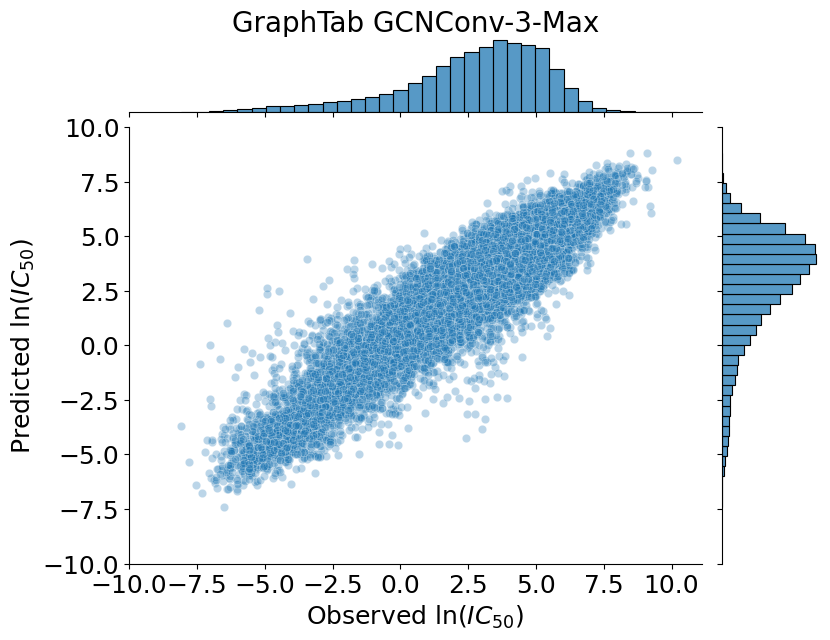

In [47]:
ic50s = pd.DataFrame({
    'y_true': [y[0] for y in y_true.tolist()],
    'y_pred': [y[0] for y in y_pred.tolist()]
})

ax = sns.jointplot(x='y_true', y='y_pred', data=ic50s, 
                   joint_kws={'alpha': 0.3},
                   marginal_kws={'bins': 35});
ax.fig.set_size_inches(8, 6);

plt.xlabel(r'Observed $\ln(IC_{50})$', fontsize=18);
plt.ylabel(r'Predicted $\ln(IC_{50})$', fontsize=18);
plt.xticks(np.arange(-10, 11, 2.5), fontsize=18);
plt.yticks(np.arange(-10, 11, 2.5), fontsize=18); 

plt.title(f'GraphTab GCNConv-3-Max', y=1.20, fontsize=20);

ax.fig.savefig(f'outputs/GraphTab_GCNConv_3_Max.png', dpi=300)

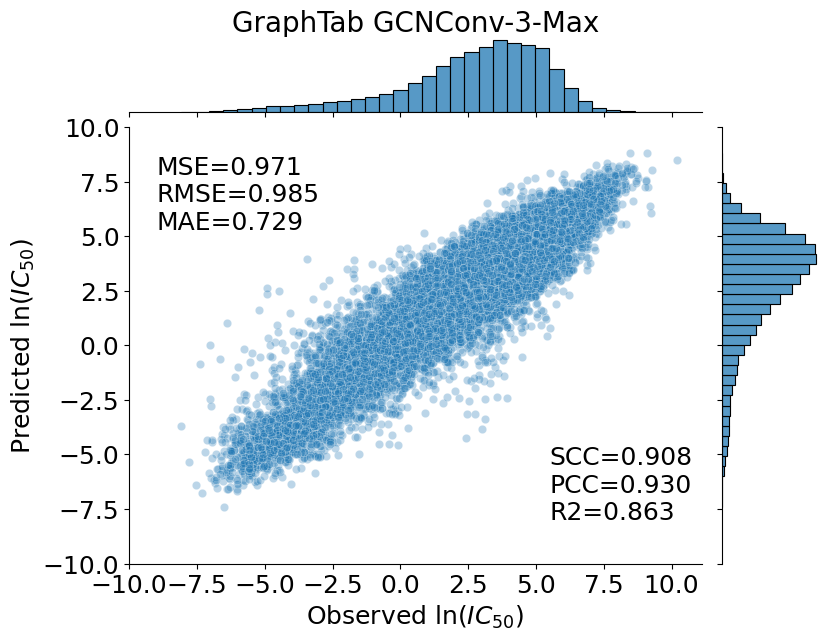

In [81]:
ic50s = pd.DataFrame({
    'y_true': [y[0] for y in y_true.tolist()],
    'y_pred': [y[0] for y in y_pred.tolist()]
})

ax = sns.jointplot(x='y_true', y='y_pred', data=ic50s, 
                   joint_kws={'alpha': 0.3},
                   marginal_kws={'bins': 35});
ax.fig.set_size_inches(8, 6);

plt.xlabel(r'Observed $\ln(IC_{50})$', fontsize=18);
plt.ylabel(r'Predicted $\ln(IC_{50})$', fontsize=18);
plt.xticks(np.arange(-10, 11, 2.5), fontsize=18);
plt.yticks(np.arange(-10, 11, 2.5), fontsize=18); 

plt.title(f'GraphTab GCNConv-3-Max', y=1.20, fontsize=20);

plt.text(-9, 5.3, 
         f"MSE={mse.item():0.3f}\n" + \
         f"RMSE={rmse.item():0.3f}\n" + \
         f"MAE={mae.item():0.3f}",
         horizontalalignment='left', size=18, color='black');

plt.text(5.5, -8.0, 
         f"SCC={scc:0.3f}\n" + \
         f"PCC={pcc:0.3f}\n" + \
         f"R2={r2:0.3f}", 
         horizontalalignment='left', size=18, color='black');

ax.fig.savefig(f'outputs/GraphTab_GCNConv_3_Max_with_metrics.png', dpi=300)

# Predicted vs Actual Per Drug

In [2]:
path_to_drm = '../../data/processed/gdsc2/gdsc2_drm.pkl'
path_to_gene_graphs = '../../data/processed/gdsc2/990/thresh_gdsc2_990_gene_graphs.pkl'
path_to_simles_graphs = '../../data/processed/gdsc2/gdsc2_smiles_graphs.pkl'
path_to_fps = '../../data/processed/gdsc2/gdsc2_smiles_dict.pkl'

with open(path_to_drm, 'rb') as f: 
    drm = pickle.load(f)
    print(f"Finished reading drug response matrix: {drm.shape}")

with open(path_to_gene_graphs, 'rb') as f:
    cl_graphs = pd.read_pickle(f)
    print(f"Finished reading cell-line graphs: {cl_graphs['22RV1']}")
# Read drug smiles graphs.
with open(path_to_simles_graphs, 'rb') as f: 
    drug_graphs = pickle.load(f)
    print(f"Finished reading drug SMILES graphs: {drug_graphs[1003]}")
    
with open(path_to_fps, 'rb') as f:
    fingerprints_dict = pickle.load(f)    

Finished reading drug response matrix: (137835, 9)
Finished reading cell-line graphs: Data(x=[293, 4], edge_index=[2, 874])
Finished reading drug SMILES graphs: Data(x=[26, 9], edge_index=[2, 60], edge_attr=[60, 3], smiles='CC[C@@]1(c2cc3c4c(cc5ccccc5n4)Cn3c(=O)c2COC1=O)O')


In [3]:
import torch
import argparse

# Load the model.
model_trained = torch.load(
    '../performances/grid_experiments/model_performance_GraphGraph_v1_gdsc2_990_42_GCNConv_2Gin990max150.pth', 
    map_location=torch.device('cpu')
)

# Simulate arguments.
parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', type=int, default=128, help='the batch size (default: 10)')
parser.add_argument('--num_workers', type=int, default=1, help='number of workers for DataLoader (default: 4)')
args, unknown = parser.parse_known_args()
print(args)

graph_tab_dataset = GraphGraphDataset(
    cl_graphs, 
    drug_graphs, 
    drm
)
print("Finished building GraphGraphDataset!")

drm_train, drm_test = train_test_split(
    drm, 
    test_size=model_trained.get('test_ratio'),
    random_state=42,
    stratify=drm['CELL_LINE_NAME']
)

train_loader, test_loader = create_gg_loaders(
    drm_train,
    drm_test,
    cl_graphs,
    drug_graphs,
    args
)

device = torch.device("cpu")
print(f"Device: {device}")

model_temp = GraphGraph(
    dropout=0.1,
    conv_type='GCNConv',
    conv_layers=2
)    

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(
    params=model_temp.parameters(), 
    lr=model_trained.get('learning_rate'),
    weight_decay=0.0
) 

model = BuildGraphGraphModel(
    model=model_temp, 
    criterion=loss_func, 
    optimizer=optimizer,
    num_epochs=model_trained.get('num_epochs'), 
    train_loader=train_loader,
    test_loader=test_loader,
    early_stopping_threshold=model_trained.get('early_stopping_thresh'),            
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)
print("Finished BuildGraphGraphModel()")

model_state_dict = model_trained.get('model_state_dict')
# model_state_dict = {k: v.to(device) for k, v in model_state_dict.items()}
for key in model_state_dict:
    model_state_dict[key] = model_state_dict[key].to(torch.device('cpu'))
    
model.device = device

model.model.load_state_dict(model_state_dict)
model.model.to(device) 

Namespace(batch_size=128, num_workers=1)
Finished building GraphGraphDataset!
Device: cpu
Finished BuildGraphGraphModel()


GraphGraph(
  (cell_emb): Sequential(
    (0): GCNConv(4, 128)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): GCNConv(128, 128)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): <function global_max_pool at 0x7f3f6404a0e0>
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Dropout(p=0.1, inplace=False)
    (10): Linear(in_features=128, out_features=128, bias=True)
    (11): ReLU()
  )
  (drug_emb): Sequential(
    (0): GINConv(nn=Sequential(
    (0): Linear(in_features=9, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
  ))
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(128, eps=1e-05, m

In [4]:
mse, rmse, mae, r2, pcc, scc, y_true, y_pred, smiles  = model.validate_with_drugs(test_loader)
print(f"Test  | MSE: {mse} | RMSE: {rmse} | MAE: {mae} | R2: {r2} | PCC: {pcc} | SCC: {scc}")  

Iteration (val): 100%|██████████| 216/216 [00:32<00:00,  6.55it/s]

Test  | MSE: 0.9722134470939636 | RMSE: 0.9860088229179382 | MAE: 0.7339352965354919 | R2: 0.8631714259271961 | PCC: 0.9290925647438848 | SCC: 0.90687316074543


In [24]:
ic50s = pd.DataFrame({
    'y_true': [y[0] for y in y_true.tolist()],
    'y_pred': [y[0] for y in y_pred.tolist()],
    'SMILES': smiles,
    'DRUG_ID': np.repeat(None, len(smiles))
})
ic50s.head(3)

,y_true,y_pred,SMILES,DRUG_ID
0,3.490013,4.551638,c1ccc(cc1)c1cc2c(ccn3c2nnc3O)nc1c1ccc(cc1)C1(C...,None
1,1.699496,2.819821,CC(C)n1c(c2cn3CCOc4cc(ccc4c3n2)c2cnn(c2)C(C)(C...,None
2,3.119330,2.454598,c1ccc(c(c1)c1cc2c(c3cc(ccc3[nH]2)O)c2c1C(=NC2=...,None


In [25]:
# Map the smiles to the respective drug id's.
for index, row in ic50s.iterrows():
    smile = row['SMILES']
    for drug_id, drug_G in drug_graphs.items():
        if drug_G.smiles == smile:
            ic50s.at[index, 'DRUG_ID'] = drug_id
ic50s.head(3)

,y_true,y_pred,SMILES,DRUG_ID
0,3.490013,4.551638,c1ccc(cc1)c1cc2c(ccn3c2nnc3O)nc1c1ccc(cc1)C1(C...,1053
1,1.699496,2.819821,CC(C)n1c(c2cn3CCOc4cc(ccc4c3n2)c2cnn(c2)C(C)(C...,1561
2,3.119330,2.454598,c1ccc(c(c1)c1cc2c(c3cc(ccc3[nH]2)O)c2c1C(=NC2=...,1046


In [32]:
# Get the drug names.
temp = pd.merge(ic50s, drm_test[['DRUG_NAME', 'DRUG_ID']].drop_duplicates(), 
                on='DRUG_ID', how='left')
print(temp.shape)
temp.head(3)

(27567, 5)


,y_true,y_pred,SMILES,DRUG_ID,DRUG_NAME
0,3.490013,4.551638,c1ccc(cc1)c1cc2c(ccn3c2nnc3O)nc1c1ccc(cc1)C1(C...,1053,MK-2206
1,1.699496,2.819821,CC(C)n1c(c2cn3CCOc4cc(ccc4c3n2)c2cnn(c2)C(C)(C...,1561,Taselisib
2,3.119330,2.454598,c1ccc(c(c1)c1cc2c(c3cc(ccc3[nH]2)O)c2c1C(=NC2=...,1046,Wee1 Inhibitor


In [44]:
top_10_highest = temp.nlargest(10, 'y_pred')['DRUG_NAME']
temp[temp['DRUG_NAME'].isin(top_10_highest)]

,y_true,y_pred,SMILES,DRUG_ID,DRUG_NAME
63,6.674890,6.873829,CC1(C)CNc2cc(ccc12)N=C(c1cccnc1NCc1ccncc1)O,1029,Motesanib
78,6.079129,5.708173,CC1(C)CNc2cc(ccc12)N=C(c1cccnc1NCc1ccncc1)O,1029,Motesanib
143,5.044696,5.644422,CCOc1c(C#N)c(cc(=NC(=O)Cc2cc(ccc2OC)OC)[nH]1)N,1043,JNK Inhibitor VIII
158,5.185065,5.156916,C=CC(=O)N1CCN(CC1)C(=O)CNc1cc(c(cc1O)Cl)I,1855,KRAS (G12C) Inhibitor-12
163,5.722117,6.187702,CCOc1c(C#N)c(cc(=NC(=O)Cc2cc(ccc2OC)OC)[nH]1)N,1043,JNK Inhibitor VIII
...,...,...,...,...,...
27532,5.023145,5.224852,c1cc2c(CN(C3CCC(=NC3=O)O)C2=O)c(c1)N,1020,Lenalidomide
27539,3.904260,4.860128,C=CC(=O)N1CCN(CC1)C(=O)CNc1cc(c(cc1O)Cl)I,1855,KRAS (G12C) Inhibitor-12
27542,6.291047,5.146940,C=CC(=O)N1CCN(CC1)C(=O)CNc1cc(c(cc1O)Cl)I,1855,KRAS (G12C) Inhibitor-12
27551,5.510056,6.177354,CC1(C)CNc2cc(ccc12)N=C(c1cccnc1NCc1ccncc1)O,1029,Motesanib


In [ ]:
top_10_lowest = temp.nsmallest(10, 'y_pred')['DRUG_ID']

In [59]:
ic50s_grouped = temp \
    .groupby(['DRUG_NAME']) \
    .agg(
        {
            'y_true': ['mean', 'median', 'std'],
            'y_pred': ['mean', 'median', 'std'],
            'DRUG_NAME': 'size'
        }
    )
ic50s_grouped.columns = ['y_true_mean', 'y_true_median', 'y_true_std', 
                         'y_pred_mean', 'y_pred_median', 'y_pred_std', 
                         'count']
ic50s_grouped.reset_index(inplace=True)
ic50s_grouped.sort_values(['count'], ascending=False).head(3)

,DRUG_NAME,y_true_mean,y_true_median,y_true_std,y_pred_mean,y_pred_median,y_pred_std,count
113,Olaparib,4.170818,4.176284,1.290315,4.115818,4.331868,1.226895,202
71,I-BRD9,4.489853,4.577292,1.224979,4.510715,4.602742,1.070464,201
46,Dactolisib,-1.340831,-1.617221,1.561466,-1.424105,-1.413348,1.193006,198


In [95]:
top_10 = ic50s_grouped.nlargest(10, 'y_true_median')
bottom_10 = ic50s_grouped.nsmallest(10, 'y_true_median').sort_values(['y_true_median'], ascending=False)
top_10

,DRUG_NAME,y_true_mean,y_true_median,y_true_std,y_pred_mean,y_pred_median,y_pred_std,count
156,Temozolomide,6.198416,6.337491,1.304377,6.234041,6.311179,1.020768,141
53,EPZ5676,5.598551,5.645951,0.977954,5.546104,5.532835,0.866435,173
102,Motesanib,5.434011,5.607987,1.114316,5.543640,5.598220,0.882497,154
43,Cyclophosphamide,5.240836,5.365653,0.902975,5.149464,5.147147,0.713945,181
93,MIRA-1,5.178853,5.347853,1.220140,5.244588,5.345117,1.048784,181
126,Picolinici-acid,5.270365,5.340843,0.900592,5.253991,5.295671,0.720143,141
87,Lenalidomide,5.251690,5.321089,1.139240,5.259633,5.324926,0.953023,162
137,SB216763,5.232367,5.267961,1.194540,5.186223,5.116460,0.729755,156
167,Veliparib,5.238502,5.218675,0.859923,5.204607,5.275173,0.788141,178
7,AZD1208,5.106640,5.210690,1.013258,5.140000,5.282688,0.816683,140


In [64]:
bottom_10

,DRUG_NAME,y_true_mean,y_true_median,y_true_std,y_pred_mean,y_pred_median,y_pred_std,count
40,Camptothecin,-1.914046,-2.092154,1.950423,-1.802389,-1.956008,1.796730,173
90,Luminespib,-2.323981,-2.739998,1.685407,-2.134876,-2.341474,1.442956,167
49,Dinaciclib,-2.512083,-2.910972,1.575770,-2.584861,-2.666577,1.192118,146
143,SN-38,-2.203288,-3.303071,3.534709,-1.749546,-2.073124,2.866204,171
123,Paclitaxel,-2.970436,-3.381745,2.022566,-2.860748,-3.059452,1.789904,154
170,Vinorelbine,-2.964130,-3.505089,2.094720,-2.947927,-3.241080,1.761424,166
169,Vinblastine,-3.303377,-4.004188,2.372935,-3.166722,-3.419544,2.068571,150
47,Daporinad,-3.388491,-4.010042,2.725401,-3.581279,-3.484963,1.655969,100
147,Sepantronium bromide,-4.205107,-4.262897,1.610255,-4.273394,-4.344850,0.636114,184
33,Bortezomib,-4.616146,-4.903374,1.190477,-5.072947,-5.082495,0.613222,168


In [96]:
temp_preds = temp[temp['DRUG_NAME'].isin(list(top_10['DRUG_NAME'].values) + list(bottom_10['DRUG_NAME'].values))]
plotting_df = pd.DataFrame()
plotting_df['DRUG_NAME'] = temp_preds['DRUG_NAME'].values.tolist() + temp_preds['DRUG_NAME'].values.tolist()
plotting_df['LN_IC50'] = temp_preds['y_true'].values.tolist() + temp_preds['y_pred'].values.tolist()
plotting_df['DATA'] = ['y_true']*temp_preds.shape[0] + ['y_pred']*temp_preds.shape[0]
print(plotting_df.shape)
plotting_df.head(3)

(6372, 3)


,DRUG_NAME,LN_IC50,DATA
0,Sepantronium bromide,-2.987943,y_true
1,Bortezomib,-5.639047,y_true
2,Vinblastine,-4.641464,y_true


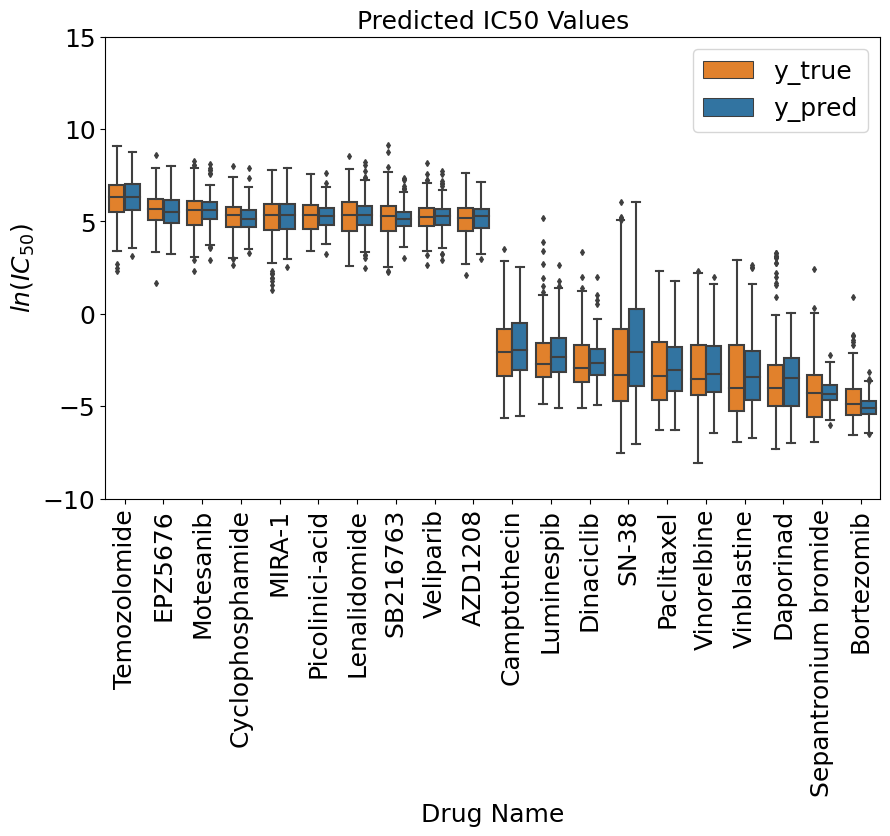

In [106]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=plotting_df,
            x='DRUG_NAME', y='LN_IC50', hue='DATA', fliersize=3, 
            palette=['C1', 'C0'],
            order=top_10['DRUG_NAME'].tolist() + bottom_10['DRUG_NAME'].tolist(),
            ax=ax);
plt.xticks(rotation=90, fontsize=18);
plt.yticks(fontsize=18);
plt.ylim(-10, 15);
plt.xlabel('Drug Name', fontsize=18)
plt.ylabel(r'$ln(IC_{50})$', fontsize=18)
plt.title('Predicted IC50 Values', fontsize=18)
plt.legend(loc='upper right', fontsize=18)
plt.show()

fig.savefig('outputs/GraphGraph_predicted_top_bottom_10_ic50s_by_drugname.png', dpi=300, bbox_inches='tight')

In [104]:
from scipy.stats import mannwhitneyu

top_10_drug_names = list(top_10['DRUG_NAME'].values)
bottom_10_drug_names = list(bottom_10['DRUG_NAME'].values)

print("Top 10 Drug Names")
print("=================")
for dn in top_10_drug_names:
    ic50_true = plotting_df[(plotting_df['DRUG_NAME']==dn) & (plotting_df['DATA']=='y_true')]
    ic50_pred = plotting_df[(plotting_df['DRUG_NAME']==dn) & (plotting_df['DATA']=='y_pred')]  
    
    mwu = mannwhitneyu(ic50_true['LN_IC50'], 
                       ic50_pred['LN_IC50'], 
                       alternative='two-sided')
    print(f"{4*' '}Drug Name: {dn:20}  p-value: {mwu.pvalue:.5}")    
    
print("Bottom 10 Drug Names")
print("====================")
for dn in bottom_10_drug_names:
    ic50_true = plotting_df[(plotting_df['DRUG_NAME']==dn) & (plotting_df['DATA']=='y_true')]
    ic50_pred = plotting_df[(plotting_df['DRUG_NAME']==dn) & (plotting_df['DATA']=='y_pred')]  
    
    mwu = mannwhitneyu(ic50_true['LN_IC50'], 
                       ic50_pred['LN_IC50'], 
                       alternative='two-sided')
    print(f"{4*' '}Drug Name: {dn:20}  p-value: {mwu.pvalue:.5}")      

Top 10 Drug Names
    Drug Name: Temozolomide          p-value: 0.95458
    Drug Name: EPZ5676               p-value: 0.41827
    Drug Name: Motesanib             p-value: 0.65101
    Drug Name: Cyclophosphamide      p-value: 0.10113
    Drug Name: MIRA-1                p-value: 0.95514
    Drug Name: Picolinici-acid       p-value: 0.66766
    Drug Name: Lenalidomide          p-value: 0.76637
    Drug Name: SB216763              p-value: 0.48487
    Drug Name: Veliparib             p-value: 0.93392
    Drug Name: AZD1208               p-value: 0.88323
Bottom 10 Drug Names
    Drug Name: Camptothecin          p-value: 0.38569
    Drug Name: Luminespib            p-value: 0.066361
    Drug Name: Dinaciclib            p-value: 0.62708
    Drug Name: SN-38                 p-value: 0.014279
    Drug Name: Paclitaxel            p-value: 0.39018
    Drug Name: Vinorelbine           p-value: 0.63876
    Drug Name: Vinblastine           p-value: 0.28482
    Drug Name: Daporinad             p-va

__Conclusion__: 



- For the top 10 drugs, all 10 of them (100%) showed no significant differences through the Mann-Whitney Wilcoxon Test
- For the bottom 10 drugs, 8 of them (80%) showed no significant differences through the Mann-Whitney Wilcoxon Test
    - 2 of them showed a p-value in < 0.05
        - Namely, _SN-38_ and _Bortezomib_
- Thus, in total, 18 drugs showed no significant differences

# Ablation Studies

```
tensor([[ GeneExpr, CnvGistic,  CnvPicnic,  Mut], 
          ...]], dtype=torch.float64)
```

In [27]:
path_to_drm = '../../data/processed/gdsc2/gdsc2_drm.pkl'
path_to_gene_graphs = '../../data/processed/gdsc2/990/thresh_gdsc2_990_gene_graphs.pkl'
path_to_simles_graphs = '../../data/processed/gdsc2/gdsc2_smiles_graphs.pkl'
path_to_fps = '../../data/processed/gdsc2/gdsc2_smiles_dict.pkl'

with open(path_to_drm, 'rb') as f: 
    drm = pickle.load(f)
    print(f"Finished reading drug response matrix: {drm.shape}")

with open(path_to_gene_graphs, 'rb') as f:
    cl_graphs = pd.read_pickle(f)
    print(f"Finished reading cell-line graphs: {cl_graphs['22RV1']}")
# Read drug smiles graphs.
with open(path_to_simles_graphs, 'rb') as f: 
    drug_graphs = pickle.load(f)
    print(f"Finished reading drug SMILES graphs: {drug_graphs[1003]}")
    
with open(path_to_fps, 'rb') as f:
    fingerprints_dict = pickle.load(f)  

Finished reading drug response matrix: (137835, 9)
Finished reading cell-line graphs: Data(x=[293, 4], edge_index=[2, 874])
Finished reading drug SMILES graphs: Data(x=[26, 9], edge_index=[2, 60], edge_attr=[60, 3], smiles='CC[C@@]1(c2cc3c4c(cc5ccccc5n4)Cn3c(=O)c2COC1=O)O')


In [28]:
cl_graphs.get('MOG-G-CCM').x

tensor([[ 4.2125, -1.0000,  2.0000,  0.0000],
        [ 7.8470, -1.0000,  2.0000,  0.0000],
        [ 3.1843, -1.0000,  2.0000,  0.0000],
        ...,
        [ 8.5080,  0.0000,  2.0000,  0.0000],
        [ 5.1487, -1.0000,  2.0000,  0.0000],
        [ 8.1139,  0.0000,  2.0000,  0.0000]], dtype=torch.float64)

In [31]:
import copy 

node_feature_mapping = {
    'gexpr': 0,
    'cnvg': 1,
    'cnvp': 2,
    'mut': 3
}

cl_graphs_subset = {}

for cl, G in cl_graphs.items():
    G_temp = copy.deepcopy(G)
    G_temp.x = G_temp.x[:, 1].unsqueeze(dim=-1)
#     G_temp.x = G_temp.x.unsqueeze(dim=-1)
    
    cl_graphs_subset[cl] = G_temp

cl_graphs_subset.get('MOG-G-CCM')   

Data(x=[293, 1], edge_index=[2, 874])

In [32]:
import torch
import argparse

# Simulate arguments.
parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', type=int, default=128, help='the batch size (default: 10)')
parser.add_argument('--num_workers', type=int, default=1, help='number of workers for DataLoader (default: 4)')
args, unknown = parser.parse_known_args()
print(args)

graph_graph_dataset = GraphGraphDataset(
    cl_graphs_subset, 
    drug_graphs, 
    drm
)
graph_graph_dataset.print_dataset_summary()

drm_train, drm_test = train_test_split(
    drm, 
    test_size=0.2,
    random_state=42,
    stratify=drm['CELL_LINE_NAME']
)

# Create data loaders.
train_loader, test_loader = create_gg_loaders(
    drm_train,
    drm_test,
    cl_graphs_subset,
    drug_graphs,
    args
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model.
model = GraphGraph(
    dropout=0.1,
    conv_type='GCNConv',
    conv_layers=2,
    global_pooling='max',
    nr_node_features=1
) 

# Enable multi-GPU parallelization if feasible.
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model).to(device)
else:
    model =  model.to(device)            

# Define loss function and optimizer.
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(
    params=model.parameters(), 
    lr=0.001,
    weight_decay=0.00
)            

# Build the model.
build_model = BuildGraphGraphModel(
    model=model, 
    criterion=loss_func, 
    optimizer=optimizer,
    num_epochs=1, 
    train_loader=train_loader,
    test_loader=test_loader,
    early_stopping_threshold=10,            
    device=device
)
build_model

Namespace(batch_size=128, num_workers=1)


In [33]:
performance_stats = build_model.train(build_model.train_loader)

Iteration (val): 100%|██████████| 216/216 [00:05<00:00, 42.96it/s]


# GNNExplainer

In [6]:
import sys
import os
import pickle
import random
import torch
import torch.nn as nn
import tqdm as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sys.path.append('/home/ec2-user/SageMaker/projects/gnn/GNN-material/src')
sys.path = list(set(sys.path))

from torch_geometric.explain import Explainer, GNNExplainer
from sklearn.model_selection import train_test_split
from models.GraphTab.graph_tab_early_stopping import GraphTabDataset, create_gt_loaders, BuildGraphTabModel, GraphTab
from models.GraphGraph.graph_graph_early_stopping import GraphGraphDataset, create_gg_loaders, BuildGraphGraphModel, GraphGraph

import torch_geometric as pyg
print("PyTorch Geometric version:", pyg.__version__)

PyTorch Geometric version: 2.2.0


In [2]:
path_to_drm = '../../data/processed/gdsc2/gdsc2_drm.pkl'
path_to_gene_graphs = '../../data/processed/gdsc2/990/thresh_gdsc2_990_gene_graphs.pkl'
path_to_simles_graphs = '../../data/processed/gdsc2/gdsc2_smiles_graphs.pkl'
path_to_fps = '../../data/processed/gdsc2/gdsc2_smiles_dict.pkl'

with open(path_to_drm, 'rb') as f: 
    drm = pickle.load(f)
    print(f"Finished reading drug response matrix: {drm.shape}")

with open(path_to_gene_graphs, 'rb') as f:
    cl_graphs = pd.read_pickle(f)
    print(f"Finished reading cell-line graphs: {cl_graphs['22RV1']}")
# Read drug smiles graphs.
with open(path_to_simles_graphs, 'rb') as f: 
    drug_graphs = pickle.load(f)
    print(f"Finished reading drug SMILES graphs: {drug_graphs[1003]}")
    
with open(path_to_fps, 'rb') as f:
    fingerprints_dict = pickle.load(f)    

Finished reading drug response matrix: (137835, 9)
Finished reading cell-line graphs: Data(x=[293, 4], edge_index=[2, 874])
Finished reading drug SMILES graphs: Data(x=[26, 9], edge_index=[2, 60], edge_attr=[60, 3], smiles='CC[C@@]1(c2cc3c4c(cc5ccccc5n4)Cn3c(=O)c2COC1=O)O')


In [63]:
import logging
import time
import torch
import torch.nn as nn
import numpy    as np

from torch_geometric.data    import Dataset
from sklearn.model_selection import train_test_split
from torch_geometric.loader  import DataLoader as PyG_DataLoader
from torch_geometric.nn      import Sequential, GCNConv, GATConv, GINConv
from torch_geometric.nn      import global_mean_pool, global_max_pool, global_add_pool
from tqdm                    import tqdm
from time                    import sleep
from sklearn.metrics         import r2_score, mean_absolute_error
from scipy.stats             import pearsonr, spearmanr
from ignite.engine           import Engine, Events
from ignite.handlers         import EarlyStopping
from functools               import partial

class GraphGraph(torch.nn.Module):
    def __init__(self, 
                 dropout, 
                 conv_type='GCNConv', 
                 conv_layers=2, 
                 global_pooling='max',
                 nr_node_features=4):
        super(GraphGraph, self).__init__()

        # Note: in_channels = number of features.
        if global_pooling == 'max':
            if conv_type == 'GCNConv':
                if conv_layers == 2:
                    self.cell_emb = Sequential('x, edge_index, batch', 
                        [
                            (GCNConv(in_channels=nr_node_features, out_channels=128), 'x, edge_index -> x1'),
                            nn.BatchNorm1d(128),
                            nn.ReLU(inplace=True),
                            (GCNConv(in_channels=128, out_channels=128), 'x1, edge_index -> x2'),
                            nn.BatchNorm1d(128),                            
                            (global_max_pool, 'x2, batch -> x3'), 
                            nn.Linear(128, 128),
                            nn.BatchNorm1d(128),
                            nn.ReLU(),
                            nn.Dropout(p=dropout),
                            nn.Linear(128, 128),
                            nn.ReLU()                          
                        ]
                    )
                elif conv_layers == 3:
                    self.cell_emb = Sequential('x, edge_index, batch', 
                        [
                            (GCNConv(in_channels=nr_node_features, out_channels=128), 'x, edge_index -> x1'),
                            nn.BatchNorm1d(128),
                            nn.ReLU(inplace=True),
                            (GCNConv(in_channels=128, out_channels=128), 'x1, edge_index -> x2'),
                            nn.BatchNorm1d(128),
                            nn.ReLU(inplace=True),
                            (GCNConv(in_channels=128, out_channels=128), 'x2, edge_index -> x3'),
                            (global_max_pool, 'x3, batch -> x4'), 
                            nn.Linear(128, 128),
                            nn.BatchNorm1d(128),
                            nn.ReLU(),
                            nn.Dropout(p=dropout),
                            nn.Linear(128, 128),
                            nn.ReLU()
                        ]
                    )                
            elif conv_type == 'GATConv':
                if conv_layers == 2:
                    self.cell_emb = Sequential('x, edge_index, batch', 
                        [
                            (GATConv(in_channels=nr_node_features, out_channels=128), 'x, edge_index -> x1'),
                            nn.BatchNorm1d(128),
                            nn.ReLU(inplace=True),
                            (GATConv(in_channels=128, out_channels=128), 'x1, edge_index -> x2'),
                            nn.BatchNorm1d(128),                            
                            (global_max_pool, 'x2, batch -> x3'), 
                            nn.Linear(128, 128),
                            nn.BatchNorm1d(128),
                            nn.ReLU(),
                            nn.Dropout(p=dropout),
                            nn.Linear(128, 128),
                            nn.ReLU()
                        ]
                    )
                elif conv_layers == 3:
                    self.cell_emb = Sequential('x, edge_index, batch', 
                        [
                            (GATConv(in_channels=nr_node_features, out_channels=128), 'x, edge_index -> x1'),
                            nn.BatchNorm1d(128),
                            nn.ReLU(inplace=True),
                            (GATConv(in_channels=128, out_channels=128), 'x1, edge_index -> x2'),
                            nn.BatchNorm1d(128),
                            nn.ReLU(inplace=True),  
                            (GATConv(in_channels=128, out_channels=128), 'x2, edge_index -> x3'),
                            nn.BatchNorm1d(128),
                            (global_max_pool, 'x3, batch -> x4'), 
                            nn.Linear(128, 128),
                            nn.ReLU(),
                            nn.Dropout(p=dropout),
                            nn.Linear(128, 128),
                            nn.ReLU(),
                            nn.Dropout(p=dropout)
                        ]
                    )                    
        elif global_pooling == 'mean':
            if conv_type == 'GCNConv':
                if conv_layers == 2:
                    self.cell_emb = Sequential('x, edge_index, batch', 
                        [
                            (GCNConv(in_channels=nr_node_features, out_channels=128), 'x, edge_index -> x1'),
                            nn.BatchNorm1d(128),
                            nn.ReLU(inplace=True),
                            (GCNConv(in_channels=128, out_channels=128), 'x1, edge_index -> x2'),
                            (global_mean_pool, 'x2, batch -> x3'), 
                            nn.Linear(128, 128),
                            nn.BatchNorm1d(128),
                            nn.ReLU(),
                            nn.Dropout(p=dropout),
                            nn.Linear(128, 128),
                            nn.ReLU()
                        ]
                    )
                elif conv_layers == 3:
                    self.cell_emb = Sequential('x, edge_index, batch', 
                        [
                            (GCNConv(in_channels=nr_node_features, out_channels=128), 'x, edge_index -> x1'),
                            nn.BatchNorm1d(128),
                            nn.ReLU(inplace=True),
                            (GCNConv(in_channels=128, out_channels=128), 'x1, edge_index -> x2'),
                            nn.BatchNorm1d(128),
                            nn.ReLU(inplace=True),
                            (GCNConv(in_channels=128, out_channels=128), 'x2, edge_index -> x3'),
                            nn.BatchNorm1d(128),                            
                            (global_mean_pool, 'x3, batch -> x4'), 
                            nn.Linear(128, 128),
                            nn.BatchNorm1d(128),
                            nn.ReLU(),
                            nn.Dropout(p=dropout),
                            nn.Linear(128, 128),
                            nn.ReLU()
                        ]
                    )                
            elif conv_type == 'GATConv':
                if conv_layers == 2:
                    self.cell_emb = Sequential('x, edge_index, batch', 
                        [
                            (GATConv(in_channels=nr_node_features, out_channels=128), 'x, edge_index -> x1'),
                            nn.BatchNorm1d(128),
                            nn.ReLU(inplace=True),
                            (GATConv(in_channels=128, out_channels=128), 'x1, edge_index -> x2'),
                            nn.BatchNorm1d(128),                            
                            (global_mean_pool, 'x2, batch -> x3'), 
                            nn.Linear(128, 128),
                            nn.BatchNorm1d(128),
                            nn.ReLU(),
                            nn.Dropout(p=dropout),
                            nn.Linear(128, 128),
                            nn.ReLU()
                        ]
                    )
                elif conv_layers == 3:
                    self.cell_emb = Sequential('x, edge_index, batch', 
                        [
                            (GATConv(in_channels=nr_node_features, out_channels=128), 'x, edge_index -> x1'),
                            nn.BatchNorm1d(128),
                            nn.ReLU(inplace=True),
                            (GATConv(in_channels=128, out_channels=128), 'x1, edge_index -> x2'),
                            nn.BatchNorm1d(128),
                            nn.ReLU(inplace=True),
                            (GATConv(in_channels=128, out_channels=128), 'x2, edge_index -> x3'),
                            nn.BatchNorm1d(128),                            
                            (global_mean_pool, 'x3, batch -> x4'), 
                            nn.Linear(128, 128),
                            nn.BatchNorm1d(128),
                            nn.ReLU(),
                            nn.Dropout(p=dropout),
                            nn.Linear(128, 128),
                            nn.ReLU()
                        ]
                    )                    
        else:
            raise ValueError(
                f"Input conv_type `{conv_type}` has not been implemented! Choose out of [`GCNConv`, `GATConv`]"
            )

        self.drug_emb = Sequential('x, edge_index, batch', 
            [
                (GINConv(
                    nn.Sequential(
                        nn.Linear(9, 128), # 9 = num_node_features
                        nn.BatchNorm1d(128),
                        nn.ReLU(),
                        nn.Linear(128, 128)
                    )
                ), 'x, edge_index -> x1'),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(128),
                (GINConv(
                    nn.Sequential(
                        nn.Linear(128, 128),
                        nn.BatchNorm1d(128),
                        nn.ReLU(),
                        nn.Linear(128, 128)
                    )
                ), 'x1, edge_index -> x2'),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(128),
                (global_max_pool, 'x2, batch -> x3'),
                nn.Linear(128, 128),
                nn.BatchNorm1d(128),
                nn.ReLU(),
                nn.Dropout(p=0.1),
                nn.Linear(128, 128),
                nn.ReLU()
            ]
        )

        self.fcn = nn.Sequential(
            nn.Linear(2*128, 128),
            nn.BatchNorm1d(128),
            nn.ELU(),
            nn.Dropout(p=dropout),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ELU(),
            nn.Dropout(p=dropout),
            nn.Linear(64, 1)
        )

#     def forward(self, cell, drug):
#         drug_emb = self.drug_emb(drug)
#         cell_emb = self.cell_emb(cell.x.float(), cell.edge_index, cell.batch)
#         concat = torch.cat([cell_emb, drug_emb], -1)
#         y_pred = self.fcn(concat)
#         y_pred = y_pred.reshape(y_pred.shape[0])
#         return y_pred   
    
    def forward(self, 
                x, 
                edge_index, 
                cell_batch, 
                drug_x, 
                drug_edge_index,
                drug_batch):
        cell_emb = self.cell_emb(x, 
                                 edge_index, 
                                 cell_batch)
        drug_emb = self.drug_emb(drug_x, 
                                 drug_edge_index, 
                                 drug_batch)        
        concat = torch.cat([cell_emb, drug_emb], -1)
        y_pred = self.fcn(concat)
        y_pred = y_pred.reshape(y_pred.shape[0])
        return y_pred  

In [304]:
import torch
import argparse

# Load the model.
model_trained = torch.load(
    '../performances/grid_experiments/model_performance_GraphGraph_v1_gdsc2_990_42_GCNConv_2Gin990max150.pth', 
    map_location=torch.device('cpu')
)

# Simulate arguments.
parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', type=int, default=128, help='the batch size (default: 10)')
parser.add_argument('--num_workers', type=int, default=1, help='number of workers for DataLoader (default: 4)')
args, unknown = parser.parse_known_args()
print(args)

graph_tab_dataset = GraphGraphDataset(
    cl_graphs, 
    drug_graphs, 
    drm
)
print("Finished building GraphGraphDataset!")

drm_train, drm_test = train_test_split(
    drm, 
    test_size=model_trained.get('test_ratio'),
    random_state=42,
    stratify=drm['CELL_LINE_NAME']
)

train_loader, test_loader = create_gg_loaders(
    drm_train,
    drm_test,
    cl_graphs,
    drug_graphs,
    args
)

device = torch.device("cpu")
print(f"Device: {device}")

model_temp = GraphGraph(
    dropout=0.1,
    conv_type='GCNConv',
    conv_layers=2
)    

model_temp.to(device) 

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(
    params=model_temp.parameters(), 
    lr=model_trained.get('learning_rate'),
    weight_decay=0.0
) 

model = BuildGraphGraphModel(
    model=model_temp, 
    criterion=loss_func, 
    optimizer=optimizer,
    num_epochs=model_trained.get('num_epochs'), 
    train_loader=train_loader,
    test_loader=test_loader,
    early_stopping_threshold=model_trained.get('early_stopping_thresh'),            
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)
print("Finished BuildGraphGraphModel()")

model_state_dict = model_trained.get('model_state_dict')
# model_state_dict = {k: v.to(device) for k, v in model_state_dict.items()}
for key in model_state_dict:
    model_state_dict[key] = model_state_dict[key].to(torch.device('cpu'))
    
model.device = device

model.model.load_state_dict(model_state_dict)
model.model.to(device) 

Namespace(batch_size=128, num_workers=1)
Finished building GraphGraphDataset!
Device: cpu
Finished BuildGraphGraphModel()


GraphGraph(
  (cell_emb): Sequential(
    (0): GCNConv(4, 128)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): GCNConv(128, 128)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): <function global_max_pool at 0x7fd0a8a877f0>
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Dropout(p=0.1, inplace=False)
    (10): Linear(in_features=128, out_features=128, bias=True)
    (11): ReLU()
  )
  (drug_emb): Sequential(
    (0): GINConv(nn=Sequential(
    (0): Linear(in_features=9, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
  ))
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(128, eps=1e-05, m

In [305]:
device = torch.device('cpu')

idx = 1
cl_drug_combi = model.test_loader.dataset[idx]
print(f"Testing for combination\n" \
       "=======================\n" \
      f"   cell-line : {model.test_loader.dataset.cell_lines[idx]}\n" \
      f"   drug      : {model.test_loader.dataset.drug_ids[idx]}\n" \
      f"{cl_drug_combi}")

G_cl = cl_drug_combi[0]
G_dr = cl_drug_combi[1]
ic50 = cl_drug_combi[2]

G_cl = G_cl.to(device)
G_dr = G_dr.to(device)
# G.y  = ic50
G_cl

Testing for combination
   cell-line : COR-L311
   drug      : 1250
(Data(x=[293, 4], edge_index=[2, 874]), Data(x=[26, 9], edge_index=[2, 56], edge_attr=[56, 3], smiles='Cc1cc(=Nc2c(cc(C#N)c(=N[C@@H](C)c3ccc(cc3)F)[nH]2)F)[nH][nH]1'), 1.680296)


Data(x=[293, 4], edge_index=[2, 874])

In [237]:
device = torch.device('cpu')
model.model.to(device)

explainer = Explainer(
    model=model.model,
    algorithm=GNNExplainer(epochs=200,
                           return_type='regression',
                           nhops=2,
                           return_mask=True),
    explainer_config=dict(
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object'
    ),
    model_config=dict(
        mode='regression',
        task_level='graph',
        return_type='raw',
    )
)
explainer

In [77]:
G_dr

Data(x=[26, 9], edge_index=[2, 56], edge_attr=[56, 3], smiles='Cc1cc(=Nc2c(cc(C#N)c(=N[C@@H](C)c3ccc(cc3)F)[nH]2)F)[nH][nH]1')

In [118]:
G_dr.x.float().shape

torch.Size([26, 9])

In [297]:
model.test_loader.batch_sampler

In [136]:
for data in model.test_loader:
    cl, dr, ic50 = data
    break
data

[DataBatch(x=[37504, 4], edge_index=[2, 111872], batch=[37504], ptr=[129]),
 DataBatch(x=[4138, 9], edge_index=[2, 9100], edge_attr=[9100, 3], smiles=[128], batch=[4138], ptr=[129]),
 tensor([ 3.7324,  1.2975,  3.6809,  3.1910, -0.8580, -0.0568,  4.8792,  5.6598,
          4.2597,  0.9253,  1.8785,  1.0004,  2.8230,  2.4739,  3.5842,  3.6948,
          5.3292,  3.9346, -1.1923,  3.9029,  1.4718,  1.8922, -0.6872,  2.0152,
          4.9205,  1.3481,  4.0724, -5.2844,  5.1146,  4.2711,  1.3914,  5.5494,
          2.9353,  5.5870,  2.7744,  1.3254,  3.3839,  4.2363,  0.6634,  4.9335,
         -3.9487,  5.5410,  0.7351,  6.3311,  3.7492, -2.0358,  0.0496,  4.8092,
          0.9685,  2.7178,  3.3654,  1.9340,  1.2332,  6.4732,  4.5549, -5.7048,
          4.0632,  6.7486,  2.1812,  4.2872,  2.5141,  4.0431, -5.3815, -0.1826,
          4.8518,  3.9896,  5.2320,  0.6411,  2.7664, -5.3570,  4.3694,  1.0946,
          4.8874,  2.8645, -4.1715,  0.5000,  5.6553,  3.6121,  4.8982,  2.6126,
       

In [278]:
cl.x[:128, :].shape

torch.Size([128, 4])

In [280]:
cl.edge_index[:, :128].shape

torch.Size([2, 128])

In [294]:
cl.batch[:128]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [289]:
dr.x[:128, :].shape

torch.Size([128, 9])

In [290]:
cl.edge_index[:, :128].shape

torch.Size([2, 128])

In [295]:
model.model(
    cl.x[:128, :].float(), 
    cl.edge_index[:, :128], 
    cl.batch[:128], 
    dr.x[:128, :].float(),
    dr.edge_index[:, :128],
    dr.batch[:128]).unsqueeze(1)

RuntimeError: index 186 is out of bounds for dimension 0 with size 128

In [326]:
dr.batch.shape

torch.Size([4172])

In [327]:
dr.edge_index.shape

torch.Size([2, 9160])

In [325]:
cl.batch.shape

torch.Size([37504])

In [328]:
cl[0]

Data(x=[293, 4], edge_index=[2, 874])

In [329]:
dr[0]

Data(x=[34, 9], edge_index=[2, 78], edge_attr=[78, 3], smiles='C[C@]1(CCCN1c1nc(=Nc2cc(C3CC3)[nH]n2)c2cccn2[nH]1)C(=Nc1ccc(F)nc1)O')

In [321]:
print(f"cl.x          : {cl.x.float().shape[0] / 128}")
print(f"cl.edge_index : {cl.edge_index.shape[1] / 128}")
print(f"cl.batch      : {cl.batch.shape[0] / 128}")
print(f"dr.x          : {dr.x.float().shape[0] / 128}")
print(f"dr.edge_index : {dr.edge_index.shape[1] / 128}")
print(f"dr.batch      : {dr.batch.shape[0] / 128}")

cl.x          : 293.0
cl.edge_index : 874.0
cl.batch      : 293.0
dr.x          : 32.59375
dr.edge_index : 71.5625
dr.batch      : 32.59375


In [334]:
with torch.no_grad():
    for data in model.test_loader:
        cl, dr, ic50 = data
        cl, dr, ic50 = cl.to(device), dr.to(device), ic50.to(device)
        cl, dr, ic50 = cl[0], dr[0], ic50[0]
        print(cl)
        print(dr)
        print(ic50)
        preds = model.model(
            cl.x.float(), 
            cl.edge_index, 
            cl.batch, 
            dr.x.float(),
            dr.edge_index,
            dr.batch
        ).unsqueeze(1)
        break
print(preds.shape)
len(preds)

Data(x=[293, 4], edge_index=[2, 874])
Data(x=[28, 9], edge_index=[2, 60], edge_attr=[60, 3], smiles='c1cc(cc(c1)N=C(c1cccc(c1O)O)O)N=C(c1cccc(c1O)O)O')
tensor(1.7281)


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 128])

In [252]:
dr.edge_index

tensor([[   0,    1,    1,  ..., 3982, 3983, 3984],
        [   1,    0,    2,  ..., 3983, 3982, 3980]])

In [254]:
dr.edge_index.shape

torch.Size([2, 8800])

In [264]:
print(cl.x.float().shape)
cl.x.float()

torch.Size([37504, 4])


tensor([[ 3.8228,  0.0000,  2.0000,  0.0000],
        [ 8.9519,  1.0000,  3.0000,  0.0000],
        [ 4.3087,  1.0000,  5.0000,  0.0000],
        ...,
        [ 9.0058, -2.0000,  4.0000,  0.0000],
        [ 4.4628,  1.0000,  4.0000,  1.0000],
        [ 8.3746, -1.0000,  3.0000,  0.0000]])

In [267]:
cl.edge_index[0].shape

torch.Size([111872])

In [273]:
cl.edge_index[:, :128].shape

torch.Size([2, 128])

In [265]:
print(cl.edge_index.shape)
cl.edge_index

torch.Size([2, 111872])


tensor([[  268,   222,   151,  ..., 37212, 37408, 37405],
        [  186,   247,   214,  ..., 37432, 37354, 37325]])

In [261]:
model.model(cl.x.float(), 
           cl.edge_index, 
           cl.batch, 
           dr.x.float(),
           dr.edge_index,
           dr.batch).unsqueeze(1)

tensor([[ 3.9675],
        [ 4.8455],
        [ 5.0975],
        [-4.5634],
        [ 4.8163],
        [-1.0763],
        [ 4.2035],
        [ 5.7448],
        [ 6.2248],
        [ 5.2075],
        [ 3.3220],
        [ 1.6271],
        [ 1.1986],
        [ 2.5807],
        [ 4.7013],
        [ 0.6731],
        [ 4.9396],
        [ 2.2006],
        [ 2.7444],
        [ 5.4589],
        [ 2.5854],
        [ 5.4144],
        [ 1.0375],
        [ 1.9353],
        [ 3.4140],
        [ 6.1794],
        [ 3.9362],
        [ 3.3727],
        [ 3.0056],
        [ 3.7913],
        [-1.9558],
        [ 4.9564],
        [ 4.7474],
        [ 2.8241],
        [ 5.7635],
        [-1.6676],
        [ 4.2383],
        [ 3.4591],
        [ 6.3413],
        [ 1.7408],
        [-4.1937],
        [ 4.7429],
        [ 2.6474],
        [ 1.9852],
        [ 4.2761],
        [-4.6422],
        [ 0.1432],
        [-0.7451],
        [-2.6315],
        [-2.7348],
        [ 4.5741],
        [ 4.8556],
        [ 1.

In [ ]:
model.model(cl.x.float(), 
           cl.edge_index, 
           cl.batch, 
           dr.x.float(),
           dr.edge_index,
           dr.batch).unsqueeze(1)

In [226]:
device = torch.device('cpu')

G_cl = G_cl.to(device)
G_dr = G_dr.to(device)
device

device(type='cpu')

In [236]:
node_index = 0
explanation = explainer(G_cl.x.float(), 
                        G_cl.edge_index,      
                        cell_batch=G_cl.batch,
                        drug_x=G_dr.x.float(),
                        drug_edge_index=G_dr.edge_index,
                        drug_batch=G_dr.batch
#                        index=node_index
                       )

DataBatch(x=[13771, 4], edge_index=[2, 41078], batch=[13771], ptr=[48])

In [308]:
node_index = 0
explanation = explainer(cl.x.float(), 
                        cl.edge_index,      
                        cell_batch=cl.batch,
                        drug_x=dr.x.float(),
                        drug_edge_index=dr.edge_index,
                        drug_batch=dr.batch,
                        index=node_index)

AssertionError: 

In [58]:


explainer = Explainer(
    model=model.model,
    algorithm=GNNExplainer(epochs=200,
                           return_type='regression',
                           nhops=2,
                           return_mask=True),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='graph',
        return_type='raw'
    ),
)

G_cl.to('cpu')

node_index = 0
explanation = explainer(G_cl.x, 
                        G_cl.edge_index, 
                        cell_batch=torch.tensor([0]),
                        drug=torch.tensor(G_dr).double().reshape(1, 256),
                        index=node_index
                        )
print(f'Generated explanations in {explanation.available_explanations}')

# explanation.visualize_feature_importance(feat_labels=['GExpr', 'CnvG', 'CnvP', 'Mut'],
#                                          top_k=10)

explanation.visualize_graph()

TypeError: Explainer.__init__() got an unexpected keyword argument 'explanation_type'

In [ ]:
# --- Example cell-line drug combination ---
idx = 0
cl_drug_combi = model.val_loader.dataset[idx]
print(f"Testing for combination\n"\
      f"   cell-line: {model.val_loader.dataset.cell_lines[idx]}\n" \
      f"   drug     : {model.val_loader.dataset.drug_ids[idx]}")
G = cl_drug_combi[0]
drug = cl_drug_combi[1]
ic50 = cl_drug_combi[2]
G.y = ic50
print(G.x.shape)
print(G.edge_index.shape)
print(G)
print(len(drug))
print(ic50)
print(G.batch)

In [ ]:
from torch_geometric.explain import Explainer, GNNExplainer

model.model.to('cpu')

explainer = Explainer(
    model=model.model,
    algorithm=GNNExplainer(epochs=200,
                           return_type='regression',
                           nhops=2,
                           return_mask=True),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='graph',
        return_type='raw'
    ),
)

G.to('cpu')

node_index = 0
explanation = explainer(G.x, 
                        G.edge_index, 
                        cell_batch=torch.tensor([0]),
                        drug=torch.tensor(drug).double().reshape(1, 256),
                        index=node_index
                        )
print(f'Generated explanations in {explanation.available_explanations}')

explanation.visualize_feature_importance(feat_labels=['GExpr', 'CnvG', 'CnvP', 'Mut'],
                                         top_k=10)

explanation.visualize_graph()

In [192]:
import os.path as osp

import torch
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.nn import GCNConv

dataset = 'Cora'
# path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', 'Planetoid')
transform = T.Compose([T.GCNNorm(), T.NormalizeFeatures()])
dataset = Planetoid('', dataset, transform=transform)
data = dataset[0]


class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, 16, normalize=False)
        self.conv2 = GCNConv(16, dataset.num_classes, normalize=False)

    def forward(self, x, edge_index, edge_weight):
        x = F.relu(self.conv1(x, edge_index, edge_weight))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return F.log_softmax(x, dim=1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    log_logits = model(data.x, data.edge_index, data.edge_weight)
    loss = F.nll_loss(log_logits[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explainer_config=dict(
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object',
    ),
    model_config=dict(
        mode='classification',
        task_level='node',
        return_type='log_probs',
    ),
)
node_index = 10
explanation = explainer(data.x, data.edge_index, index=node_index,
                        edge_weight=data.edge_weight)
print(f'Generated explanations in {explanation.available_explanations}')

Processing...
Done!


Generated explanations in ['node_feat_mask', 'edge_mask']


In [193]:
data.x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [194]:
data.edge_index

tensor([[   0,    0,    0,  ..., 2705, 2706, 2707],
        [ 633, 1862, 2582,  ..., 2705, 2706, 2707]], device='cuda:0')